# Description

This notebook contains the interpretation of a cluster (which features/latent variables in the original data are useful to distinguish traits in the cluster).

See section [LV analysis](#lv_analysis) below

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

from clustering.methods import ClusterInterpreter
from data.recount2 import LVAnalysis
from data.cache import read_data
import conf

# Settings

In [3]:
# PARTITION_K = 26
# PARTITION_CLUSTER_ID = 18

# Load MultiPLIER summary

In [4]:
multiplier_model_summary = read_data(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [5]:
multiplier_model_summary.shape

(2157, 5)

In [6]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [7]:
INPUT_SUBSET = "z_score_std"

In [8]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [9]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [10]:
data = pd.read_pickle(input_filepath)

In [11]:
data.shape

(3752, 987)

In [12]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.695006,1.962565,0.057683,0.878731,-0.539977,1.481272,-0.396422,1.090180,0.759223,0.931395,...,1.129784,1.752343,-1.411403,2.823863,0.931116,-1.054519,0.432982,-0.633597,0.554279,-0.642479
100002_raw-Energy,-1.528127,-0.345309,-0.148953,-0.242060,0.373427,0.791092,0.263477,0.987702,0.354391,1.416059,...,0.224604,0.769882,-0.509482,0.091153,2.286789,-1.008256,-0.029764,1.737229,-0.272107,-0.526125
100003_raw-Protein,-0.704572,-1.011299,0.671420,0.143991,0.615212,0.874212,-0.040998,0.915170,0.254369,-0.084237,...,1.003019,1.044314,-2.376108,0.004778,0.053714,-0.892447,-0.183800,1.377991,-0.278794,-0.419733
100004_raw-Fat,-0.989832,-1.875490,0.261555,-1.420719,0.366238,1.167049,0.257387,0.717674,-0.997664,0.969825,...,0.585913,0.638314,0.119139,-0.140204,1.394326,-1.173402,0.555058,1.013982,-0.544506,-0.064061
100005_raw-Carbohydrate,-0.580143,0.243335,0.158966,-0.036558,0.068176,-0.202639,1.101281,0.675227,1.463432,1.010078,...,-0.249108,-0.026814,0.232713,0.323682,1.168642,-0.282935,0.653105,1.909526,0.199997,-1.656894


## Clustering partitions

In [13]:
CONSENSUS_CLUSTERING_DIR = Path(
    conf.RESULTS["CLUSTERING_DIR"], "consensus_clustering"
).resolve()

display(CONSENSUS_CLUSTERING_DIR)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/clustering/consensus_clustering')

In [14]:
input_file = Path(CONSENSUS_CLUSTERING_DIR, "best_partitions_by_k.pkl").resolve()
display(input_file)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/clustering/consensus_clustering/best_partitions_by_k.pkl')

In [15]:
best_partitions = pd.read_pickle(input_file)

In [16]:
best_partitions.shape

(59, 4)

In [17]:
best_partitions.head()

,method,partition,ari_median,selected
k,,,,
11,scc_025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.090231,True
13,scc_025,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",0.090222,True
14,scc_025,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.090138,True
22,scc_020,"[1, 19, 19, 19, 19, 19, 19, 19, 19, 1, 19, 19,...",0.090117,True
12,scc_025,"[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...",0.089742,True


# Functions

In [18]:
def show_cluster_stats(data, partition, cluster):
    cluster_traits = data[partition == cluster].index
    display(f"Cluster '{cluster}' has {len(cluster_traits)} traits")
    display(cluster_traits)

# LV analysis
<a id="lv_analysis"></a>

## Associated traits

In [19]:
# display(best_partitions.loc[PARTITION_K])
# part = best_partitions.loc[PARTITION_K, "partition"]

In [20]:
# show_cluster_stats(data, part, PARTITION_CLUSTER_ID)

## Associated latent variables

In [21]:
# ci = ClusterInterpreter(
#     threshold=1.0,
#     max_features=20,
#     max_features_to_explore=100,
# )

In [22]:
# ci.fit(data, part, PARTITION_CLUSTER_ID)

In [23]:
# ci.features_

In [24]:
# # save interpreter instance
# output_dir = Path(
#     conf.RESULTS["CLUSTERING_INTERPRETATION"]["BASE_DIR"],
#     "cluster_lvs",
#     f"part{PARTITION_K}",
# )
# output_dir.mkdir(exist_ok=True, parents=True)

In [25]:
# output_file = Path(
#     output_dir, f"cluster_interpreter-part{PARTITION_K}_k{PARTITION_CLUSTER_ID}.pkl"
# )
# display(output_file)

In [26]:
# ci.features_.to_pickle(output_file)

## Top attributes

In [27]:
lvs_list = "LV881,LV116,LV743,LV38,LV841,LV163,LV161,LV931,LV9,LV536,LV50,LV707,LV142,LV95,LV97,LV74,LV66,LV974,LV678,LV879".split(
    ","
)

,pathway,LV index,AUC,p-value,FDR
1964,REACTOME_CELL_CYCLE,881,0.766938,4.883532e-19,8.609162e-17
1965,PID_ATR_PATHWAY,881,0.883379,4.322956e-05,5.389951e-04
1966,PID_FANCONI_PATHWAY,881,0.828724,1.587698e-04,1.638595e-03
1967,REACTOME_DNA_REPAIR,881,0.814754,2.461055e-08,6.101720e-07
1968,REACTOME_MITOTIC_M_M_G1_PHASES,881,0.785967,3.049635e-10,1.096344e-08
1969,PID_E2F_PATHWAY,881,0.659340,1.043011e-02,4.880204e-02
1970,KEGG_BASE_EXCISION_REPAIR,881,0.860503,3.154983e-04,2.847405e-03
1971,REACTOME_DNA_STRAND_ELONGATION,881,0.990600,1.647407e-06,2.820203e-05


SRP042161, SRP050499, SRP066834, SRP060416, SRP057196, SRP055569, SRP018525, SRP059035, SRP028301, SRP062773, SRP033135, SRP050440, SRP059379, SRP048603, SRP044917, SRP041102, SRP059775, SRP048604, SRP034711, SRP035312, SRP055101, SRP055153, SRP014428, SRP041255, SRP042286, SRP021509, SRP045570, SRP018838, SRP060370, SRP030617, SRP064457, SRP015138, SRP007461, SRP053186, SRP064259, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (34 != 35)
  warnings.warn(


''

30260_raw-Mean_reticulocyte_volume                         5.890030
30040_raw-Mean_corpuscular_volume                          4.745784
30270_raw-Mean_sphered_cell_volume                         4.593069
1717-Skin_colour                                           4.314437
1747_2-Hair_colour_natural_before_greying_Red              4.184030
1727-Ease_of_skin_tanning                                  4.103523
30050_raw-Mean_corpuscular_haemoglobin                     3.954470
50_raw-Standing_height                                     3.622642
23129_raw-Trunk_fatfree_mass                               3.561915
30070_raw-Red_blood_cell_erythrocyte_distribution_width    3.539809
23130_raw-Trunk_predicted_mass                             3.522084
23102_raw-Whole_body_water_mass                            3.338114
30010_raw-Red_blood_cell_erythrocyte_count                 3.292494
23101_raw-Whole_body_fatfree_mass                          3.263647
23105_raw-Basal_metabolic_rate                  

''

,gene_name,LV881,gene_band
0,MCM7,3.976067,7q22.1
1,CDC45,3.588157,22q11.21
2,PRIM1,3.445345,12q13.3
3,MCM4,3.420215,8q11.21
4,RFC4,3.372605,3q27.3
5,RFC5,3.363940,12q24.23
6,FANCI,3.339942,15q26.1
7,PCNA,3.267518,20p12.3
8,MCM6,3.155560,2q21.3
9,MCM2,3.125547,3q21.3


tissue       0.025542
cell type    0.018750
dtype: float64

array(['SRP066834', 'SRP057196', 'SRP035312', 'SRP014428', 'SRP042286'],
      dtype=object)

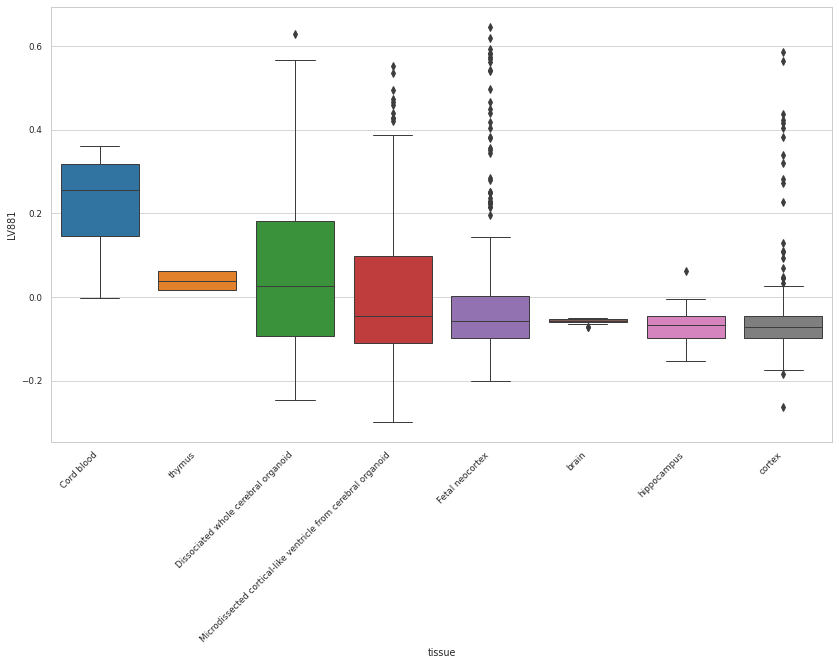

array(['SRP042161', 'SRP060416', 'SRP057196', 'SRP055569', 'SRP018525',
       'SRP059035', 'SRP033135', 'SRP059379', 'SRP044917', 'SRP041102',
       'SRP035312', 'SRP055101', 'SRP055153', 'SRP014428', 'SRP042286',
       'SRP021509', 'SRP045570', 'SRP060370', 'SRP015138', 'SRP064259'],
      dtype=object)

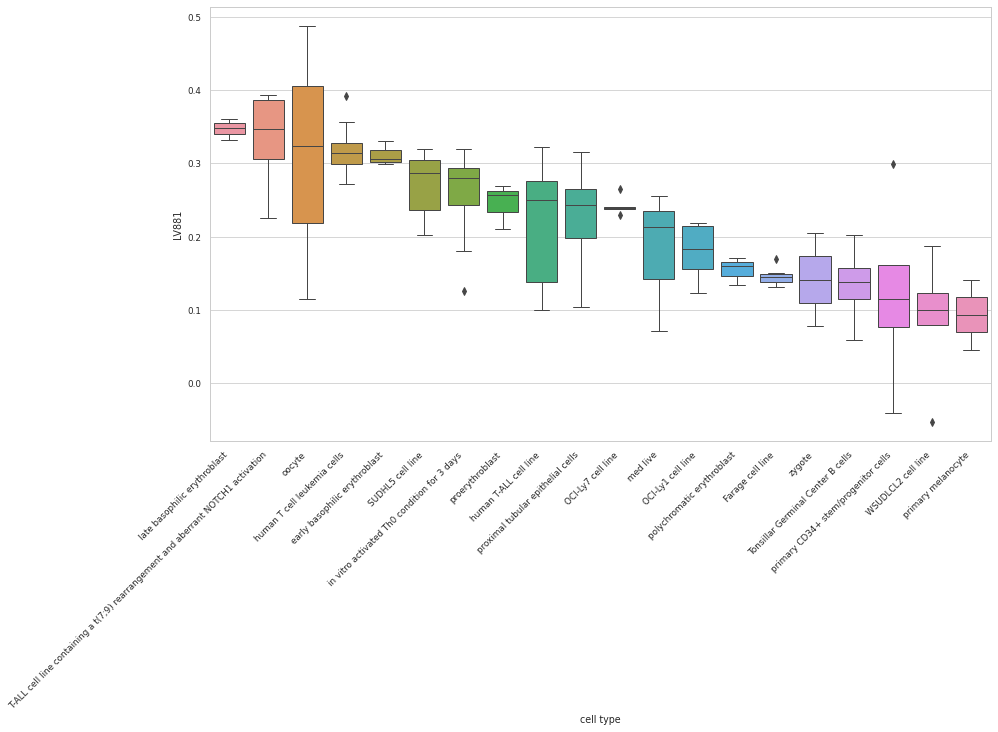

,pathway,LV index,AUC,p-value,FDR
505,IRIS_DendriticCell-LPSstimulated,116,0.645137,9.919094e-05,1.094389e-03
506,SVM Macrophages M1,116,0.922351,1.151361e-06,2.086963e-05
507,REACTOME_NEGATIVE_REGULATORS_OF_RIG_I_MDA5_SIG...,116,0.805977,2.594296e-03,1.608016e-02
508,REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM,116,0.670073,1.046582e-05,1.525323e-04
509,KEGG_CYTOSOLIC_DNA_SENSING_PATHWAY,116,0.842774,3.599076e-04,3.224361e-03
510,REACTOME_INTERFERON_SIGNALING,116,0.842482,8.398377e-11,3.483711e-09
511,REACTOME_INTERFERON_ALPHA_BETA_SIGNALING,116,0.937090,1.995367e-06,3.362506e-05


SRP059039, SRP045500, SRP063059, SRP045569, SRP015670, SRP059531, SRP062958, SRP039361, SRP056733, SRP060370, SRP062966, SRP045352, SRP048804, SRP032775, SRP059172, SRP050246, SRP064458, SRP033711, SRP049820, SRP023199, SRP060416, SRP005279, SRP042161, SRP059701, SRP068139, SRP051848, SRP014428, SRP063661, SRP057205, SRP041826, SRP059057, SRP064259, SRP046226, SRP044956, SRP066356, SRP048640, SRP041885, SRP045659, SRP041647, SRP045565, SRP041620, SRP053186, SRP045441, SRP022133, SRP055874, SRP029990, SRP044206, SRP065763, SRP056443, SRP041538, SRP044593, SRP019270, SRP067934, SRP059035, SRP019936, SRP054971, SRP058237, SRP051368, SRP019758, 

''

22601_24323289-Job_coding_town_planner_development_officer                                                                                                                                  4.013633
20118_13-Home_area_population_density_urban_or_rural_Scotland_Accessible_Small_Town                                                                                                         3.814243
100730-Spirits_intake                                                                                                                                                                       3.597783
22617_2432-Job_SOC_coding_Town_planners                                                                                                                                                     3.548626
20003_1141145668-Treatmentmedication_code_diovan_40mg_capsule                                                                                                                               3.533416
III_BLOOD_IMMUN

''

,gene_name,LV116,gene_band
0,IFIT1,6.937650,10q23.31
1,MX1,6.650584,21q22.3
2,IFIT2,6.479595,10q23.31
3,OAS3,6.311481,12q24.13
4,OASL,6.212510,12q24.31
5,IFIT3,5.990415,10q23.31
6,OAS2,5.873026,12q24.13
7,OAS1,5.701188,12q24.13
8,MX2,5.549364,21q22.3
9,RSAD2,5.244291,2p25.2


tissue          0.097682
cell type       0.056706
cell subtype    0.035469
tissue type     0.017317
dtype: float64

array(['SRP059039', 'SRP062966', 'SRP032775', 'SRP059172', 'SRP049820',
       'SRP005279', 'SRP014428', 'SRP044956', 'SRP041620', 'SRP022133',
       'SRP055874', 'SRP029990', 'SRP041538', 'SRP067934', 'SRP058237'],
      dtype=object)

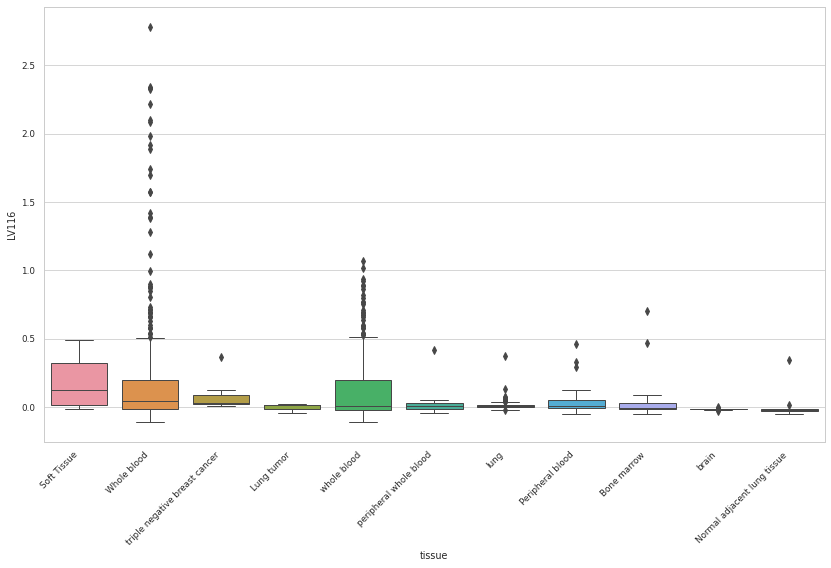

array(['SRP063059', 'SRP045569', 'SRP015670', 'SRP059531', 'SRP062958',
       'SRP039361', 'SRP060370', 'SRP045352', 'SRP048804', 'SRP050246',
       'SRP060416', 'SRP005279', 'SRP042161', 'SRP059701', 'SRP068139',
       'SRP014428', 'SRP041826', 'SRP064259', 'SRP046226', 'SRP066356',
       'SRP041885', 'SRP041647', 'SRP045441', 'SRP044206', 'SRP056443',
       'SRP044593', 'SRP059035', 'SRP054971', 'SRP058237', 'SRP019758'],
      dtype=object)

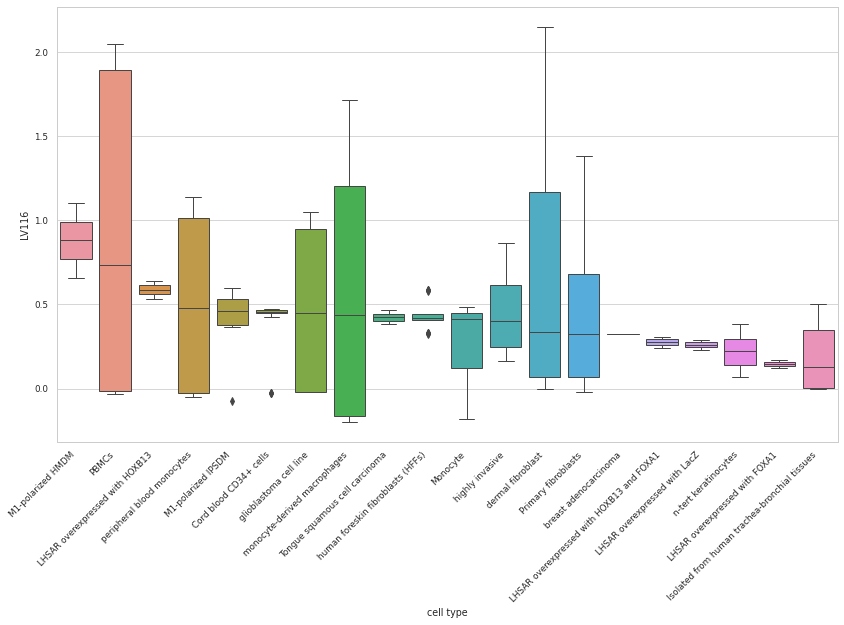

array(['SRP063661'], dtype=object)

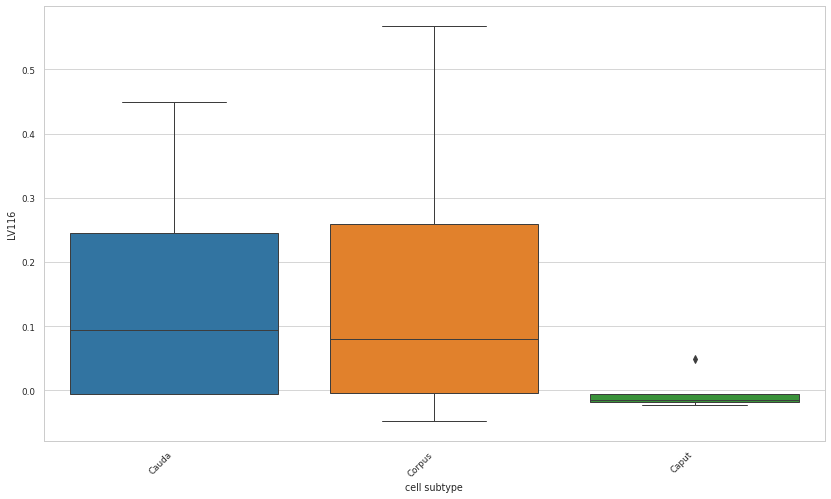

array(['SRP044956', 'SRP019936'], dtype=object)

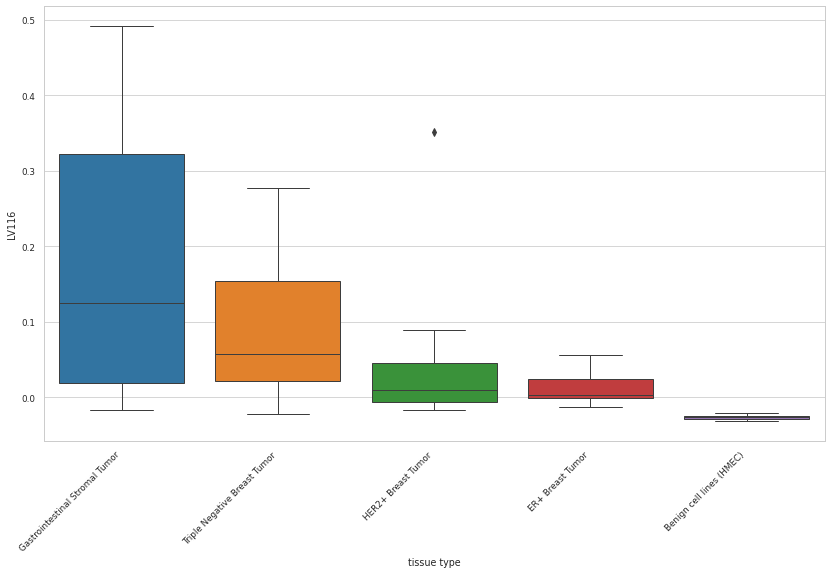

,pathway,LV index,AUC,p-value,FDR
1723,REACTOME_MITOCHONDRIAL_PROTEIN_IMPORT,743,0.750456,0.002862,0.017243
1728,KEGG_PARKINSONS_DISEASE,743,0.676448,0.001846,0.012523
1730,MIPS_55S_RIBOSOME_MITOCHONDRIAL,743,0.770444,0.000058,0.000690


SRP059775, SRP028301, SRP018838, SRP011185, SRP030617, SRP050992, SRP014428, SRP055810, SRP062025, SRP042161, SRP059035, SRP058840, SRP066834, 

''

22601_41413308-Job_coding_telephonist_telephoneswitchboard_operator                                                                                  3.202483
22601_21212592-Job_coding_civil_engineer                                                                                                             3.054841
22601_11373019-Job_coding_research_or_laboratory_manager                                                                                             3.027809
22617_4141-Job_SOC_coding_Telephonists                                                                                                               2.969281
3581_raw-Age_at_menopause_last_menstrual_period                                                                                                      2.929638
estrogen-receptor positive breast cancer                                                                                                             2.871062
disorder of appendix                                

''

,gene_name,LV743,gene_band
0,PRDX3,3.587281,10q26.11
1,NPM1,3.267455,5q35.1
2,SLC25A5,3.240670,NaN
3,MRPL39,3.076255,21q21.3
4,MRPL13,3.000511,8q24.12
5,EEF1E1,2.920906,6p24.3
6,MAD2L1,2.788358,4q27
7,SRP9,2.759075,1q42.12
8,SDHD,2.676249,11q23.1
9,MRPL42,2.673689,12q22


cell type         0.043801
cell phenotype    0.025850
tissue            0.017187
dtype: float64

array(['SRP050992', 'SRP014428', 'SRP042161', 'SRP059035'], dtype=object)

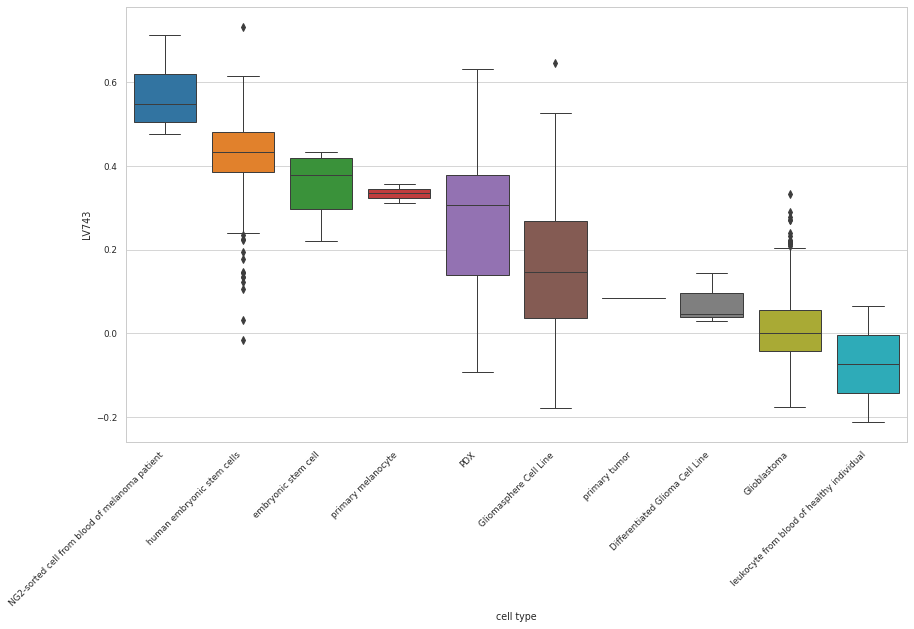

array(['SRP062025'], dtype=object)

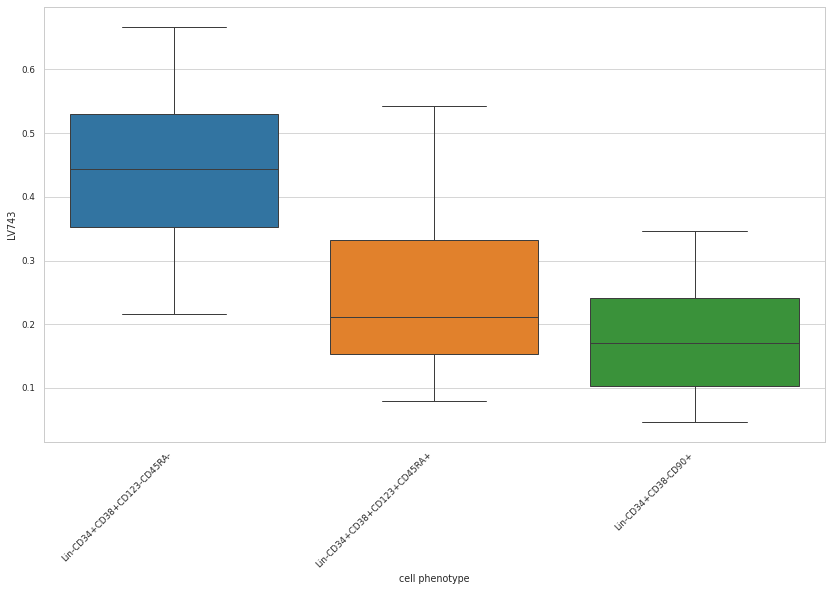

array(['SRP014428', 'SRP062025', 'SRP066834'], dtype=object)

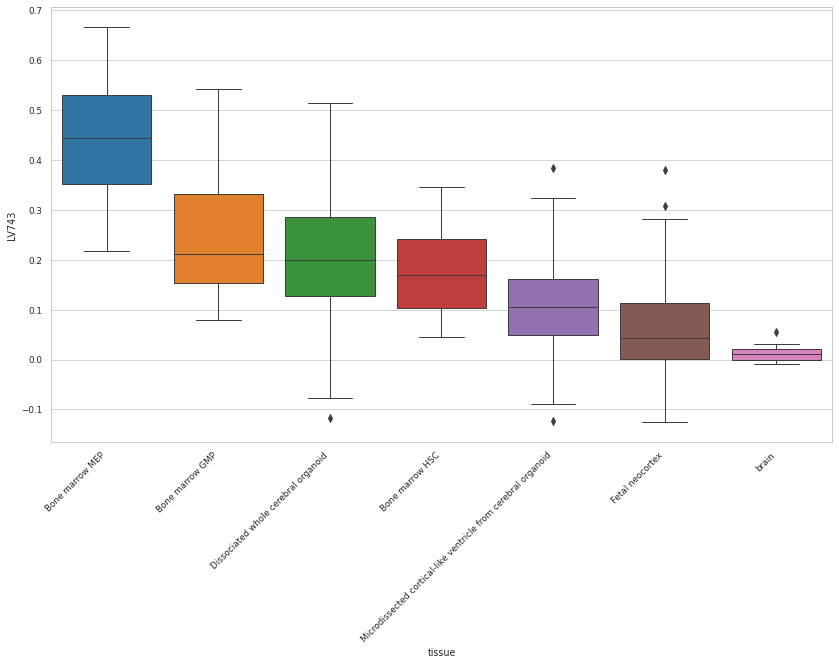

,pathway,LV index,AUC,p-value,FDR
199,REACTOME_APC_C_CDC20_MEDIATED_DEGRADATION_OF_M...,38,0.835096,7.676890e-07,0.000015
200,PID_FOXM1PATHWAY,38,0.827610,2.827471e-04,0.002618
201,REACTOME_DNA_REPLICATION,38,0.720906,8.831124e-08,0.000002
202,REACTOME_MITOTIC_G2_G2_M_PHASES,38,0.722758,4.495670e-04,0.003910
203,PID_AURORA_B_PATHWAY,38,0.742338,5.376717e-03,0.028157
204,PID_PLK1_PATHWAY,38,0.795189,4.470561e-04,0.003904


SRP066834, SRP050499, SRP042161, SRP057196, SRP033135, SRP028301, SRP055153, SRP059775, SRP059035, SRP030617, SRP058773, SRP055569, SRP052294, SRP060598, SRP055810, SRP028570, SRP055101, SRP011546, SRP050992, SRP062177, SRP015138, SRP014428, 

''

20003_1141150620-Treatmentmedication_code_zolmitriptan                              3.740262
6144_2-Never_eat_eggs_dairy_wheat_sugar_Dairy_products                              3.427854
22617_4135-Job_SOC_coding_Library_assistantsclerks                                  3.336711
22501_raw-Year_ended_full_time_education                                            3.198808
22601_41353316-Job_coding_library_assistantclerk_press_cuttings_clerk               3.150388
cerebral palsy                                                                      3.133688
radius fracture                                                                     3.038702
20450-Feelings_of_worthlessness_during_worst_period_of_depression                   2.992026
6138_5-Qualifications_NVQ_or_HND_or_HNC_or_equivalent                               2.939863
L12_NAILNAS-Other_and_unspecified_nail_disorders                                    2.928823
M13_SHOULDER-Shoulder_lesions                                         

''

,gene_name,LV38,gene_band
0,CENPF,5.366098,1q41
1,CCNB2,5.266376,15q22.2
2,TOP2A,4.840531,17q21.2
3,KPNA2,4.784421,17q24.2
4,NEK2,4.781691,1q32.3
5,CENPE,4.766468,4q24
6,BIRC5,4.717570,17q25.3
7,CCNB1,4.562655,5q13.2
8,KIF23,4.431166,15q23
9,UBE2C,4.402066,20q13.12


tissue       0.113836
cell type    0.022452
dtype: float64

array(['SRP066834', 'SRP057196', 'SRP011546', 'SRP014428'], dtype=object)

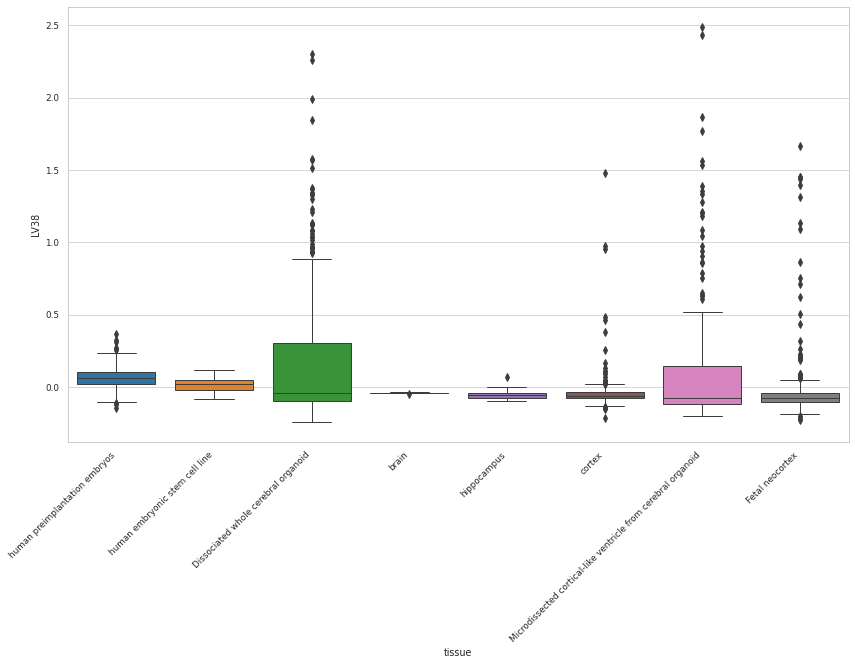

array(['SRP042161', 'SRP057196', 'SRP033135', 'SRP055153', 'SRP059035',
       'SRP055569', 'SRP055101', 'SRP011546', 'SRP050992', 'SRP062177',
       'SRP015138', 'SRP014428'], dtype=object)

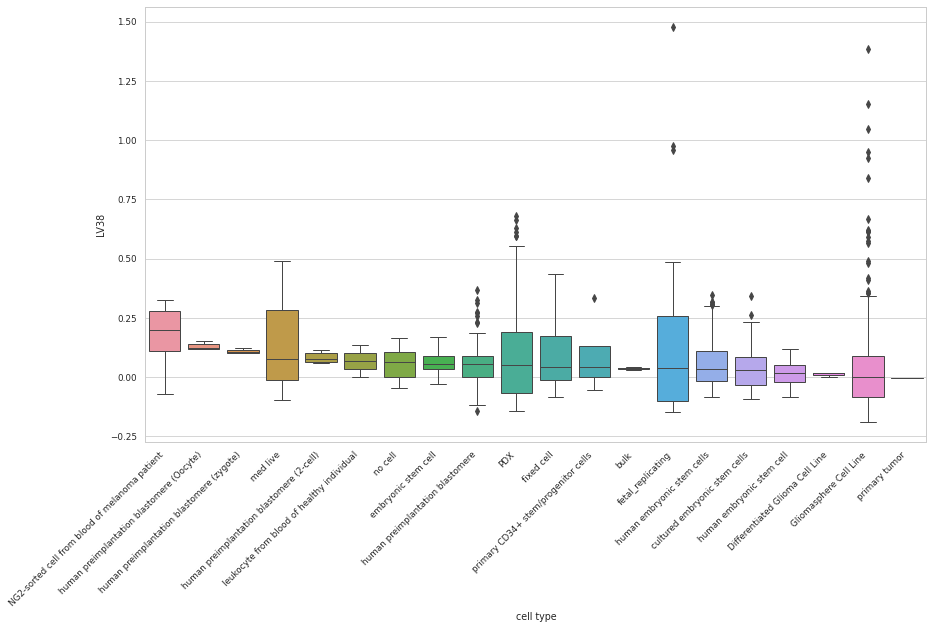

,pathway,LV index,AUC,p-value,FDR


SRP057205, SRP051102, SRP007461, SRP034666, SRP014591, SRP015964, SRP057745, SRP042620, SRP017972, SRP021214, SRP018719, SRP049004, SRP055101, SRP038702, SRP010038, SRP008331, SRP017142, SRP039348, SRP061426, SRP059692, SRP009659, SRP006970, SRP014842, SRP001893, SRP045639, SRP052706, SRP026537, SRP048761, SRP013773, SRP056076, SRP006912, SRP012295, SRP067836, SRP052740, SRP009474, SRP038963, SRP022913, SRP050374, SRP043593, SRP055475, SRP044763, SRP004637, SRP011903, SRP002079, SRP012557, SRP043960, SRP007481, SRP037718, SRP018883, SRP016790, SRP043644, SRP018861, SRP049391, SRP059643, SRP033250, SRP029434, SRP061380, SRP020544, SRP045501, SRP031849, SRP017378, SRP040327, SRP051595, SRP060650, SRP040243, SRP021134, SRP033711, SRP043510, SRP007338, SRP050954, SRP045421, SRP058804, SRP042184, SRP051674, SRP007403, SRP052879, SRP017294, SRP051772, SRP044611, SRP018218, SRP041228, SRP028570, SRP010054, SRP046266, SRP006561, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (82 != 85)
  warnings.warn(


''

30080_raw-Platelet_count                                        5.595864
30090_raw-Platelet_crit                                         4.369393
50_raw-Standing_height                                          4.173453
20015_raw-Sitting_height                                        4.025346
23117_raw-Leg_fatfree_mass_left                                 3.930132
23130_raw-Trunk_predicted_mass                                  3.927548
23118_raw-Leg_predicted_mass_left                               3.921109
23129_raw-Trunk_fatfree_mass                                    3.916435
platelet count                                                  3.913688
23101_raw-Whole_body_fatfree_mass                               3.875371
23102_raw-Whole_body_water_mass                                 3.827506
23121_raw-Arm_fatfree_mass_right                                3.740150
23105_raw-Basal_metabolic_rate                                  3.739898
23113_raw-Leg_fatfree_mass_right                   

''

,gene_name,LV841,gene_band
0,HUWE1,2.825866,NaN
1,DYNC1H1,2.726632,14q32.31
2,MYH9,2.663758,22q12.3
3,FLNA,2.637014,NaN
4,NDST1,2.581659,5q33.1
5,NOTCH2,2.547009,1p12
6,PLXNA1,2.539725,3q21.3
7,CDC42BPB,2.528263,14q32.32
8,PRPF8,2.426853,17p13.3
9,SPTAN1,2.424911,9q34.11


tissue       0.031253
cell type    0.024983
dtype: float64

array(['SRP042620', 'SRP038702', 'SRP039348', 'SRP004637', 'SRP011903',
       'SRP007481', 'SRP051595', 'SRP040243'], dtype=object)

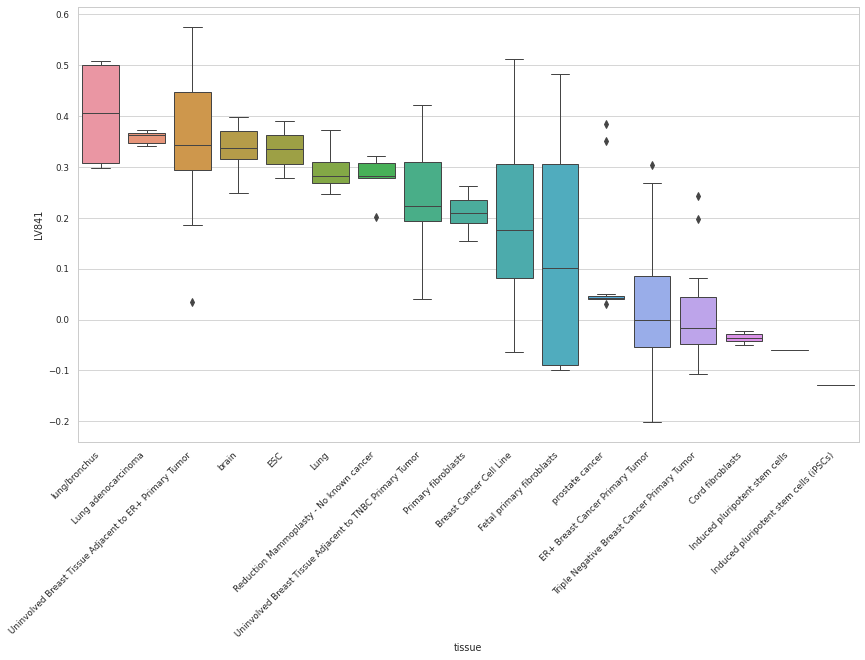

array(['SRP051102', 'SRP021214', 'SRP055101', 'SRP038702', 'SRP010038',
       'SRP017142', 'SRP061426', 'SRP006970', 'SRP001893', 'SRP045639',
       'SRP052706', 'SRP026537', 'SRP048761', 'SRP056076', 'SRP006912',
       'SRP012295', 'SRP067836', 'SRP052740', 'SRP009474', 'SRP038963',
       'SRP050374', 'SRP044763', 'SRP011903', 'SRP037718', 'SRP043644',
       'SRP061380', 'SRP060650', 'SRP021134', 'SRP050954', 'SRP058804',
       'SRP051674', 'SRP052879', 'SRP051772', 'SRP044611', 'SRP018218',
       'SRP041228', 'SRP006561'], dtype=object)

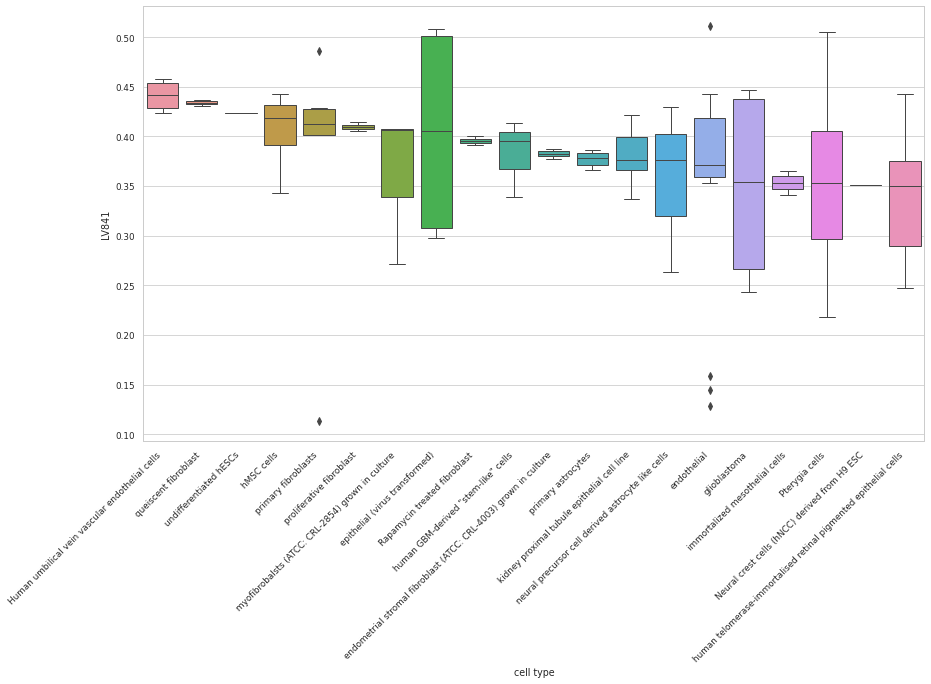

,pathway,LV index,AUC,p-value,FDR


SRP019936, SRP045639, SRP017142, SRP052706, SRP007596, SRP009276, SRP042579, SRP039348, SRP064481, SRP008554, SRP012557, SRP019994, SRP010038, SRP051674, SRP028902, SRP051765, SRP061426, SRP007461, SRP060708, SRP034953, SRP022920, SRP065202, SRP051606, SRP055153, SRP017644, SRP017972, SRP051599, SRP016790, SRP021134, SRP044013, SRP045869, SRP063620, SRP060598, SRP063948, SRP014790, SRP026537, SRP013984, SRP014320, SRP034601, SRP017789, SRP049988, SRP028118, SRP018861, SRP040243, SRP017788, SRP017411, SRP049061, SRP046254, SRP066917, SRP009266, SRP034873, SRP002915, SRP067529, SRP042620, SRP014842, SRP041718, SRP057814, SRP008218, SRP059643, SRP032165, SRP067214, SRP033711, SRP046376, SRP023270, SRP015909, SRP045711, SRP017378, SRP032942, SRP057253, SRP028190, SRP052879, SRP067836, SRP004637, SRP049068, SRP017019, SRP045695, SRP063070, SRP052740, SRP068139, SRP018218, SRP039598, SRP059066, SRP017575, SRP061380, SRP051485, SRP055475, SRP003726, SRP043510, SRP014190, SRP006912, SRP019207,

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (95 != 99)
  warnings.warn(


''

30110_raw-Platelet_distribution_width                                                  5.240518
30080_raw-Platelet_count                                                               4.235145
platelet count                                                                         4.000343
sum of eosinophil and basophil counts                                                  3.890153
alzheimer's disease                                                                    3.804511
20003_1141191044-Treatmentmedication_code_levothyroxine_sodium                         3.764629
eosinophil count                                                                       3.657890
30090_raw-Platelet_crit                                                                3.628683
22599-Number_of_jobs_held                                                              3.454838
22601_81392801-Job_coding_other_assembler_routine_operative                            3.245428
H7_RETINALDETACH-Retinal_detachments_and

''

,gene_name,LV163,gene_band
0,TNFRSF12A,3.489695,16p13.3
1,DRAP1,2.409505,11q13.1
2,PPP1R14B,2.254099,11q13.1
3,FOSL1,2.132650,11q13.1
4,GPC1,1.902764,2q37.3
5,KIFC3,1.884087,16q21
6,BCAR1,1.881304,16q23.1
7,MGAT4B,1.807862,5q35.3
8,EPHA2,1.769765,1p36.13
9,SQSTM1,1.730322,5q35.3


tissue type    0.037933
cell type      0.029207
tissue         0.024456
dtype: float64

array(['SRP019936'], dtype=object)

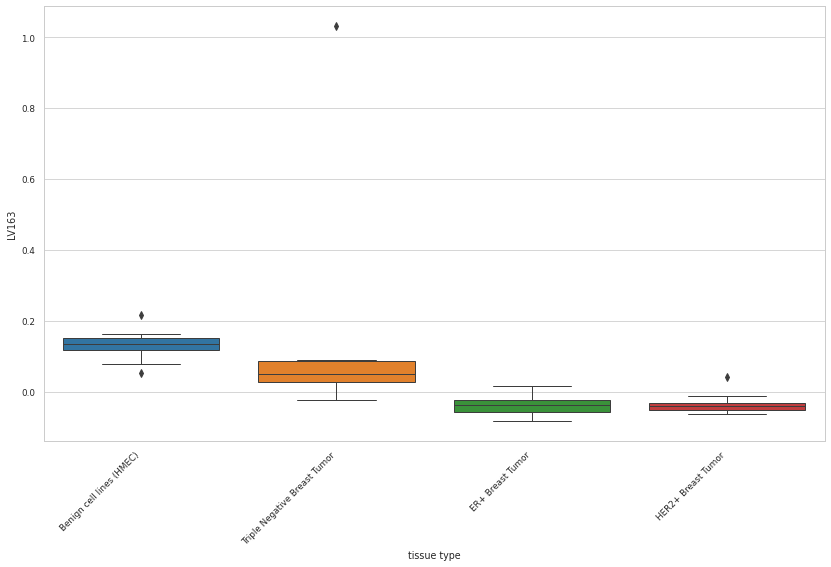

array(['SRP045639', 'SRP017142', 'SRP052706', 'SRP007596', 'SRP009276',
       'SRP042579', 'SRP008554', 'SRP010038', 'SRP051674', 'SRP028902',
       'SRP051765', 'SRP061426', 'SRP060708', 'SRP022920', 'SRP065202',
       'SRP051606', 'SRP055153', 'SRP017644', 'SRP051599', 'SRP021134',
       'SRP063620', 'SRP063948', 'SRP026537', 'SRP034601', 'SRP049988',
       'SRP028118', 'SRP017411', 'SRP049061', 'SRP046254', 'SRP066917',
       'SRP034873', 'SRP057814', 'SRP008218', 'SRP015909', 'SRP045711',
       'SRP032942', 'SRP057253', 'SRP028190', 'SRP052879', 'SRP067836',
       'SRP049068', 'SRP017019', 'SRP052740', 'SRP068139', 'SRP018218',
       'SRP059066', 'SRP061380', 'SRP003726', 'SRP006912', 'SRP057613',
       'SRP065282', 'SRP020493', 'SRP013402', 'SRP004847'], dtype=object)

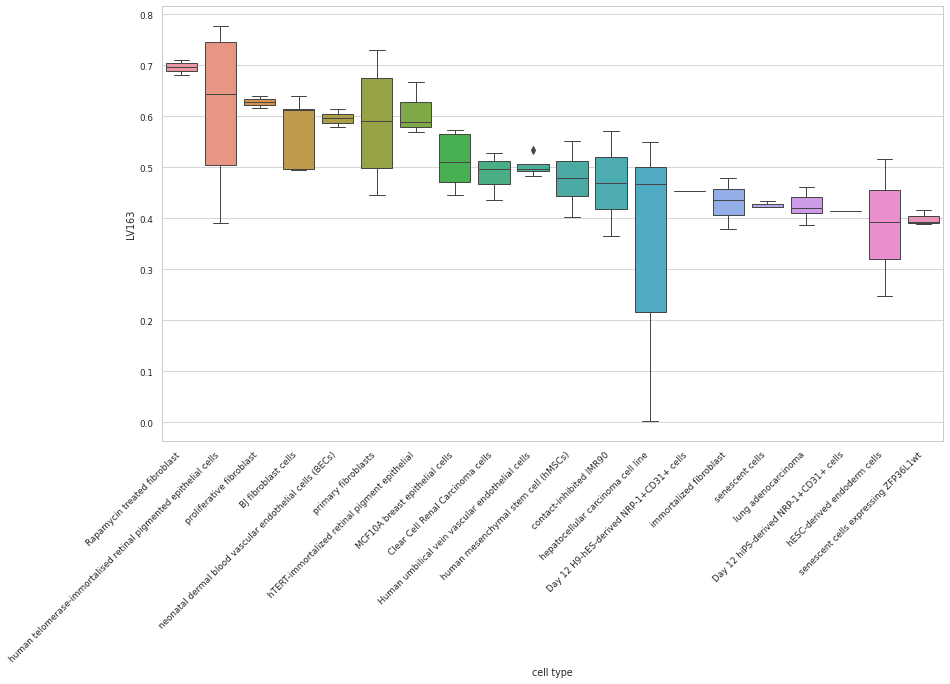

array(['SRP042579', 'SRP039348', 'SRP019994', 'SRP034953', 'SRP045869',
       'SRP040243', 'SRP042620', 'SRP008218', 'SRP032165', 'SRP004637',
       'SRP063070', 'SRP017575', 'SRP003726', 'SRP004847'], dtype=object)

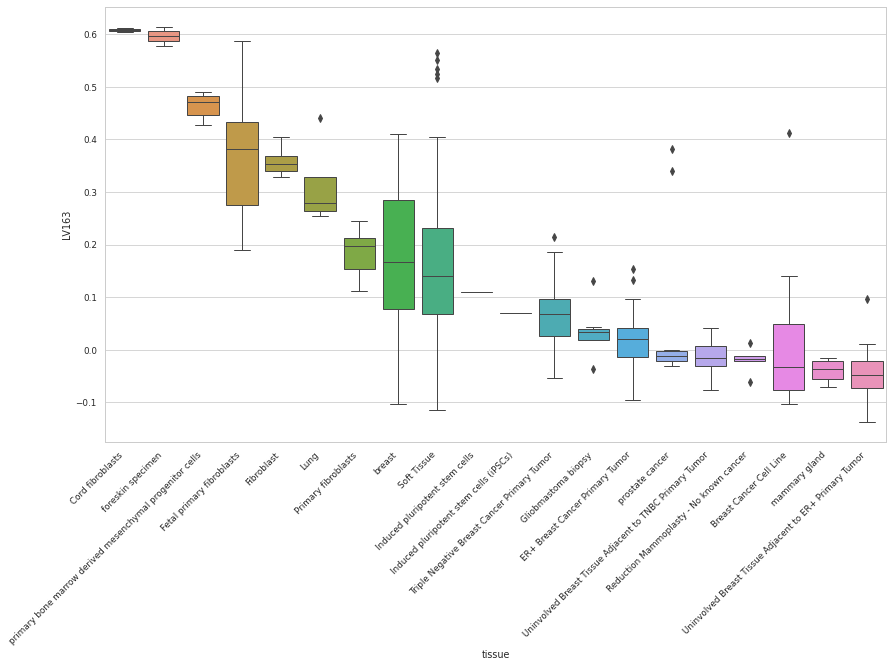

,pathway,LV index,AUC,p-value,FDR
670,KEGG_AMINOACYL_TRNA_BIOSYNTHESIS,161,0.949489,1.017918e-06,0.000019
672,REACTOME_TRNA_AMINOACYLATION,161,0.950880,9.456820e-07,0.000018


SRP061840, SRP004637, SRP058783, SRP012557, SRP019758, SRP042161, SRP018218, SRP049591, SRP014320, SRP064259, SRP032754, SRP042620, SRP026537, SRP058773, SRP024274, SRP035312, SRP034711, SRP003901, SRP066834, SRP018312, SRP037775, SRP062230, SRP043621, SRP063661, SRP059701, SRP057745, SRP014790, SRP021214, SRP048640, SRP042249, SRP020493, SRP041036, SRP022913, SRP016059, SRP051583, SRP041825, SRP061932, SRP055569, SRP012651, SRP060416, SRP051606, SRP010038, SRP050493, SRP028282, SRP044171, SRP018883, SRP014428, SRP048700, SRP008930, SRP057196, SRP015964, SRP033466, SRP041130, SRP021509, SRP033135, SRP030617, SRP059379, SRP009615, SRP045711, SRP028301, SRP007461, SRP043960, SRP002326, SRP031478, SRP041956, SRP056036, SRP009266, SRP057205, SRP055810, SRP049462, SRP029739, SRP007338, SRP027258, SRP005342, SRP044610, SRP011974, SRP012099, SRP049988, SRP062773, SRP016118, SRP056086, SRP022166, SRP028887, SRP055153, SRP042184, SRP049714, SRP063840, SRP061243, SRP017577, SRP057448, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (86 != 90)
  warnings.warn(


''

22617_8133-Job_SOC_coding_Routine_inspectors_and_testers                                3.765756
22617_3217-Job_SOC_coding_Pharmaceutical_dispensers                                     3.554849
20003_1140865588-Treatmentmedication_code_pentasa_sr_250mg_mr_tablet                    3.532044
22601_32173088-Job_coding_pharmaceutical_dispenser_pharmacy_technician                  3.499994
6149_2-Mouthteeth_dental_problems_Painful_gums                                          3.455435
22610_0-Workplace_full_of_chemical_or_other_fumes_Rarelynever                           3.134233
peripheral nervous system disease                                                       3.032968
22660_102-Gap_coding_Unpaid_or_voluntary_work                                           3.022193
20003_1141174520-Treatmentmedication_code_symbicort_1006_turbohaler                     2.948097
aortic aneurysm                                                                         2.919292
22617_1172-Job_SOC_coding_Poli

''

,gene_name,LV161,gene_band
0,TRIB3,4.140169,20p13
1,YARS,3.489505,1p35.1
2,MARS,3.345164,12q13.3
3,GARS,3.322071,7p14.3
4,AARS,3.215426,16q22.1
5,EPRS,2.934141,1q41
6,IARS,2.886201,9q22.31
7,PCK2,2.768597,14q11.2
8,PSAT1,2.583131,9q21.2
9,NARS,2.550657,18q21.31


cell subtype    0.035175
cell type       0.011559
tissue          0.006177
dtype: float64

array(['SRP063661'], dtype=object)

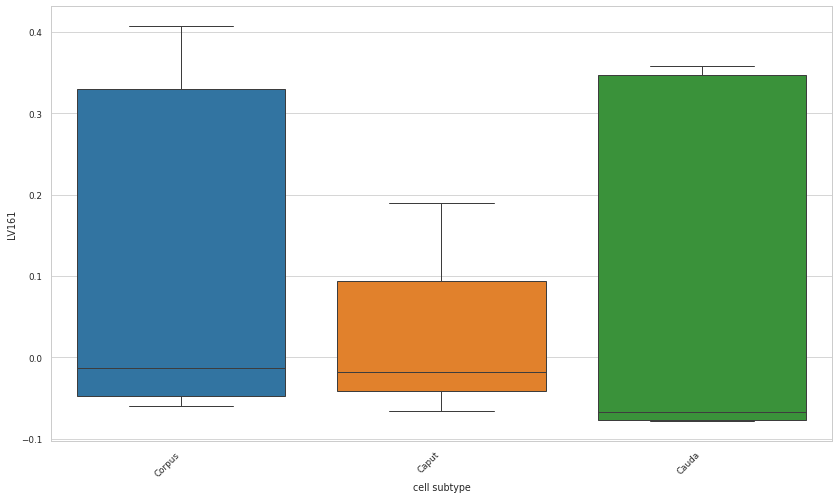

array(['SRP019758', 'SRP042161', 'SRP018218', 'SRP064259', 'SRP026537',
       'SRP024274', 'SRP035312', 'SRP018312', 'SRP037775', 'SRP062230',
       'SRP059701', 'SRP021214', 'SRP042249', 'SRP020493', 'SRP016059',
       'SRP041825', 'SRP061932', 'SRP055569', 'SRP012651', 'SRP060416',
       'SRP051606', 'SRP010038', 'SRP014428', 'SRP057196', 'SRP021509',
       'SRP033135', 'SRP059379', 'SRP045711', 'SRP031478', 'SRP041956',
       'SRP027258', 'SRP044610', 'SRP049988', 'SRP016118', 'SRP055153',
       'SRP049714', 'SRP063840', 'SRP017577'], dtype=object)

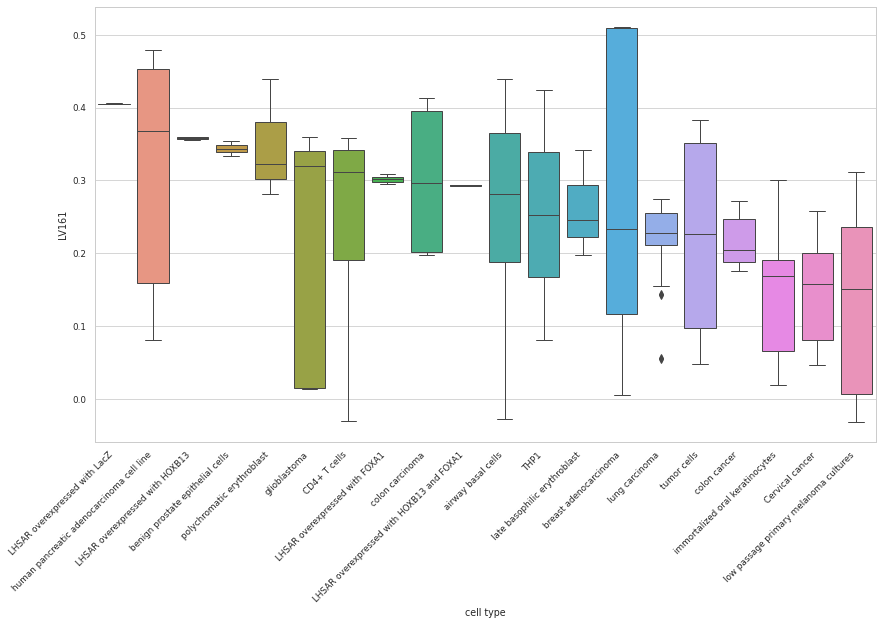

array(['SRP004637', 'SRP042620', 'SRP035312', 'SRP003901', 'SRP066834',
       'SRP016059', 'SRP061932', 'SRP014428', 'SRP057196', 'SRP002326',
       'SRP061243'], dtype=object)

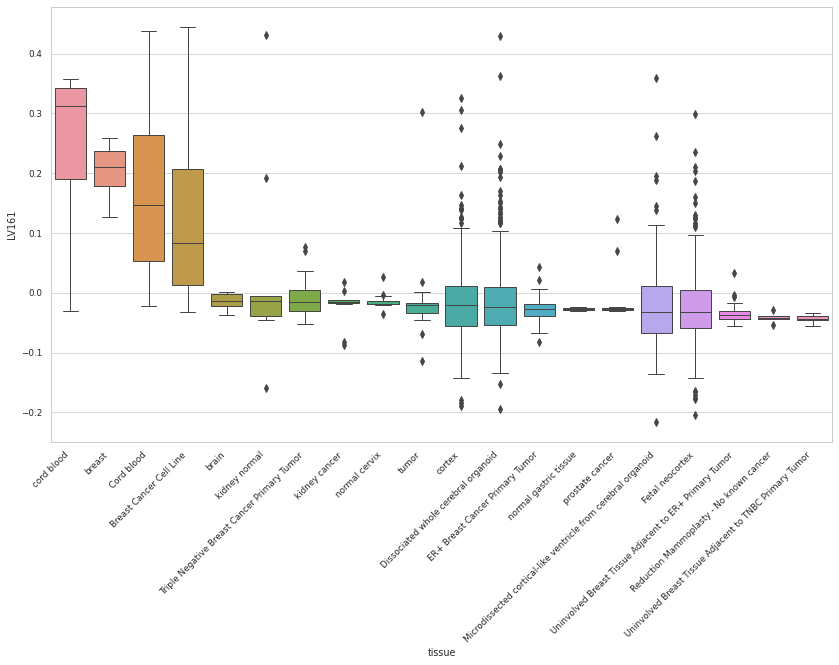

,pathway,LV index,AUC,p-value,FDR
2049,MIPS_SPLICEOSOME,931,0.634804,0.006035,0.031293
2050,PID_TGFBRPATHWAY,931,0.708098,0.008138,0.039896


SRP056295, SRP017138, SRP043080, SRP048759, SRP021191, SRP028594, SRP056197, SRP050272, SRP059735, SRP028554, SRP061932, SRP033266, SRP005279, SRP055390, SRP050493, SRP046233, SRP035679, SRP043033, SRP041885, SRP027358, SRP045500, SRP045352, SRP015360, SRP053046, 

''

inflammatory bowel disease                                                                                                                       3.956483
20003_1199-Treatmentmedication_code_food_supplementplantherbal_extract                                                                           3.681822
22601_23213026-Job_coding_scientific_researcher_scientific_officer_medical_research_associate_experimental_officer                               3.513203
lens disease                                                                                                                                     3.315518
20003_1140876136-Treatmentmedication_code_beconase_50micrograms_nasal_spray                                                                      3.213231
CARDIAC_ARRHYTM-Cardiac_arrhytmias_COPD_comorbidities                                                                                            3.183813
L12_EPIDERMALTHICKOTH-Other_epidermal_thickening                            

''

,gene_name,LV931,gene_band
0,PER1,3.808422,17p13.1
1,MEF2D,3.090195,1q22
2,FOSL2,2.855936,2p23.2
3,RELT,2.831571,11q13.4
4,H1FX,2.815111,3q21.3
5,GNA15,2.733091,19p13.3
6,GNA13,2.345263,17q24.1
7,MCL1,2.329089,1q21.2
8,MED13L,2.245489,12q24.21
9,ELF1,2.218887,13q14.11


cell type       0.056178
tissue          0.047787
cell subtype    0.014120
dtype: float64

array(['SRP056295', 'SRP043080', 'SRP048759', 'SRP021191', 'SRP056197',
       'SRP059735', 'SRP061932', 'SRP033266', 'SRP005279', 'SRP055390',
       'SRP046233', 'SRP043033', 'SRP041885', 'SRP045352', 'SRP053046'],
      dtype=object)

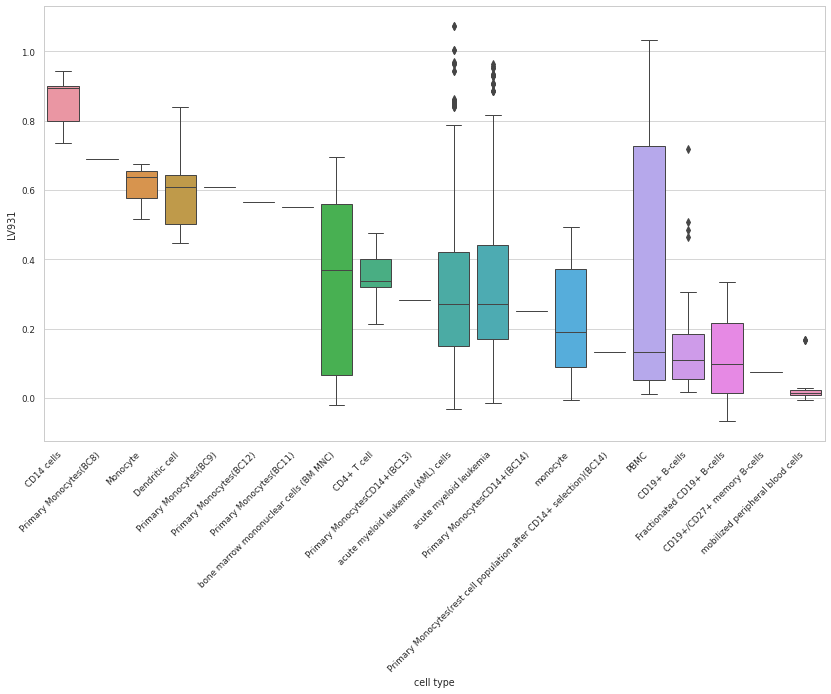

array(['SRP056295', 'SRP048759', 'SRP028594', 'SRP056197', 'SRP059735',
       'SRP028554', 'SRP061932', 'SRP033266', 'SRP005279', 'SRP055390',
       'SRP027358'], dtype=object)

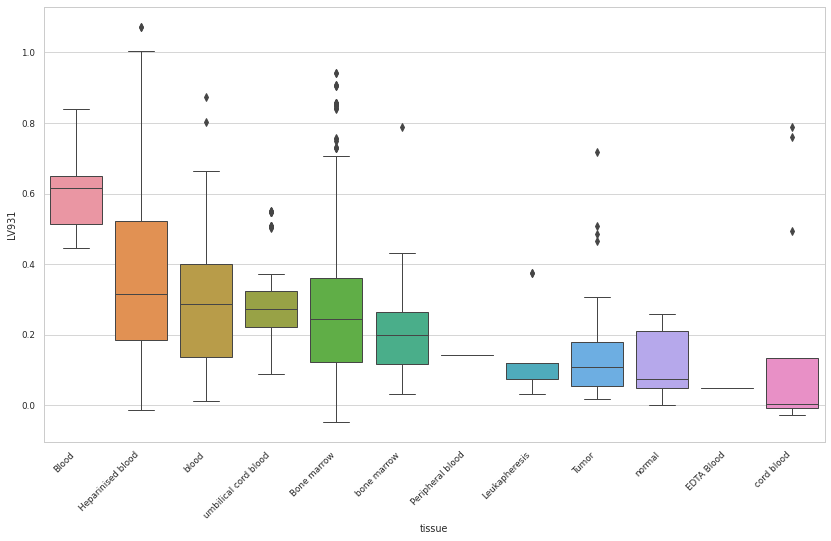

array(['SRP059735'], dtype=object)

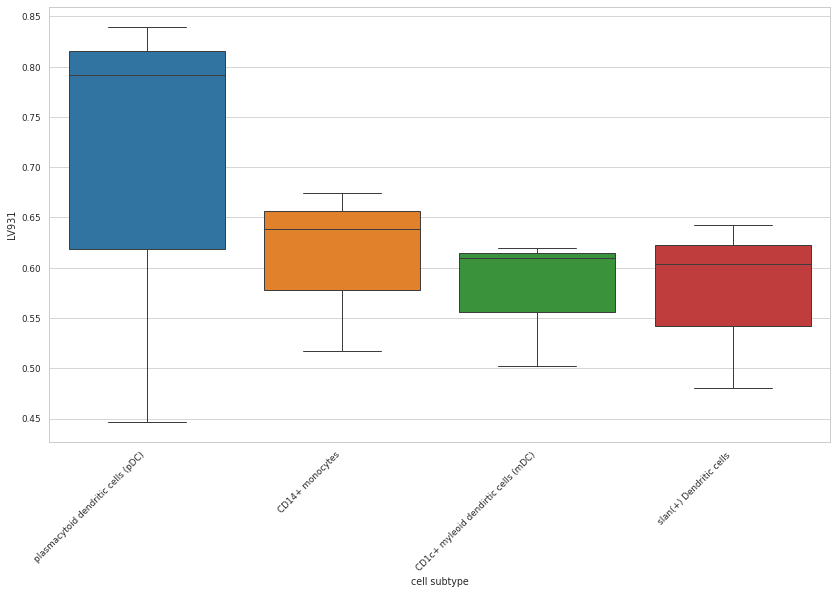

,pathway,LV index,AUC,p-value,FDR


SRP017575, SRP019994, SRP036821, SRP006575, SRP023262, SRP033276, SRP034953, SRP036053, SRP022920, SRP009276, SRP007596, SRP044956, SRP045869, 

''

30050_raw-Mean_corpuscular_haemoglobin                          6.908878
30040_raw-Mean_corpuscular_volume                               6.155522
30270_raw-Mean_sphered_cell_volume                              4.556460
30010_raw-Red_blood_cell_erythrocyte_count                      4.272364
erythrocyte count                                               4.192528
49_raw-Hip_circumference                                        4.166525
3144_raw-Heel_Broadband_ultrasound_attenuation_direct_entry     4.119502
30260_raw-Mean_reticulocyte_volume                              4.092735
3148_raw-Heel_bone_mineral_density_BMD                          4.066819
78_raw-Heel_bone_mineral_density_BMD_Tscore_automated           4.032080
3147_raw-Heel_quantitative_ultrasound_index_QUI_direct_entry    4.031900
23099_raw-Body_fat_percentage                                   3.939014
23123_raw-Arm_fat_percentage_left                               3.925730
23119_raw-Arm_fat_percentage_right                 

''

,gene_name,LV9,gene_band
0,YIPF2,4.178663,19p13.2
1,RPL36,4.036590,19p13.3
2,P2RY11,3.909784,19p13.2
3,RPL28,3.811236,19q13.42
4,FAM89B,3.673295,11q13.1
5,CARM1,3.655711,19p13.2
6,RPS15,3.472011,19p13.3
7,RFNG,3.407214,17q25.3
8,NDUFA11,3.312046,19p13.3
9,RPS11,3.266296,19q13.33


cell type         0.179296
tissue            0.076500
tissue type       0.037992
tissue subtype    0.034716
dtype: float64

array(['SRP006575', 'SRP022920', 'SRP009276', 'SRP007596'], dtype=object)

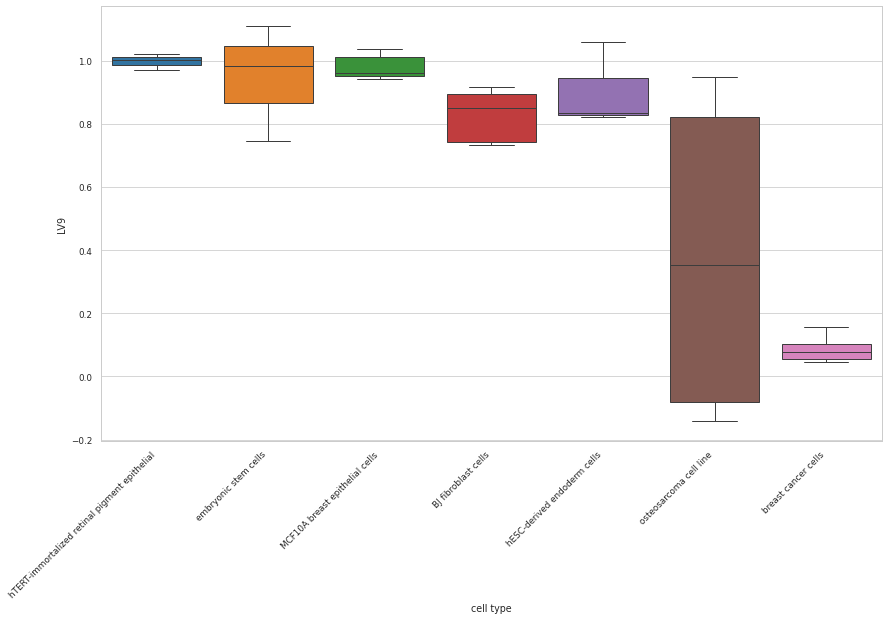

array(['SRP017575', 'SRP019994', 'SRP036821', 'SRP006575', 'SRP023262',
       'SRP033276', 'SRP034953', 'SRP036053', 'SRP044956', 'SRP045869'],
      dtype=object)

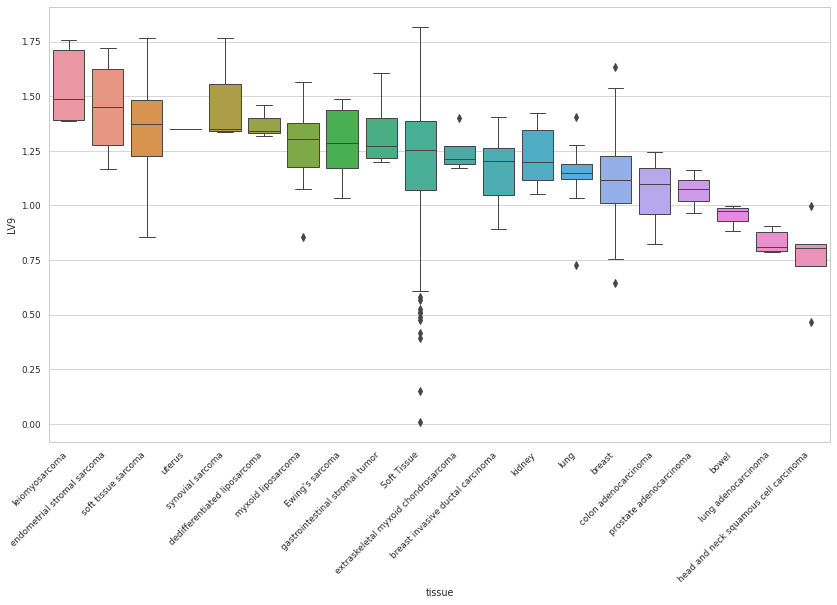

array(['SRP044956'], dtype=object)

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:430: UserWarning: Single value for tissue type: 0.865586404723399
  warnings.warn(f"Single value for {imp_f}: {cat_order}")


array(['SRP036821'], dtype=object)

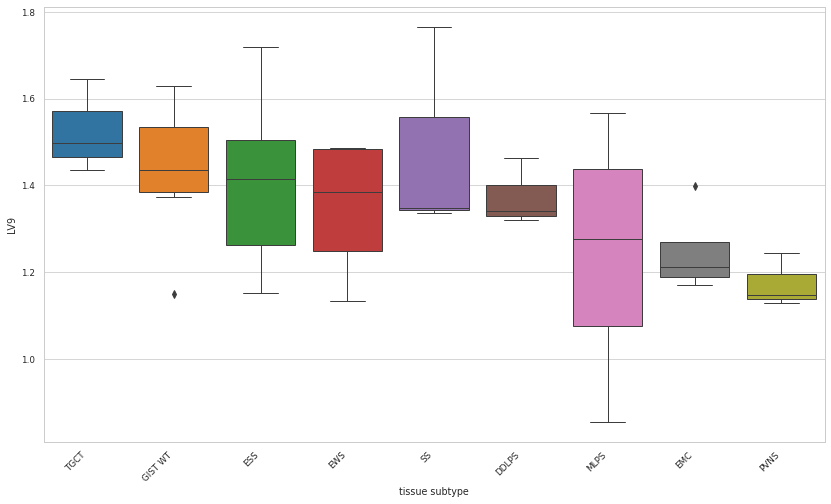

,pathway,LV index,AUC,p-value,FDR


SRP007947, SRP003901, SRP055569, SRP037722, SRP008218, SRP066834, SRP015013, SRP060416, SRP019994, SRP057196, SRP042161, SRP058773, SRP012557, SRP050499, SRP055153, SRP059379, SRP030617, SRP005279, SRP051606, SRP003754, SRP058841, SRP009247, SRP050497, SRP018104, SRP007508, SRP008145, SRP041377, SRP002326, SRP035478, SRP033135, SRP017777, SRP055440, SRP057248, SRP000599, SRP013450, SRP014213, SRP055513, SRP042218, SRP034543, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (37 != 39)
  warnings.warn(


''

20003_1140861954-Treatmentmedication_code_fenofibrate                                                                    4.294382
104530-Orange_intake                                                                                                     3.900886
I9_HEARTFAIL_NS-Heart_failure_not_strict                                                                                 3.529004
I9_HEARTFAIL-Heart_failurestrict                                                                                         3.529004
HEARTFAIL-Heart_failure                                                                                                  3.529004
syncope                                                                                                                  3.498068
22601_24513035-Job_coding_librarian_assistant_librarian                                                                  3.399424
6141_8-How_are_people_in_household_related_to_participant_Other_unrelated                 

''

,gene_name,LV536,gene_band
0,GTF2IRD1,6.397333,7q11.23
1,TAGLN,5.519838,11q23.3
2,HIST3H2BB,4.543711,1q42.13
3,PIAS1,3.546184,15q23
4,TMEM71,3.175580,8q24.22
5,PCBP1,2.948925,2p13.3
6,EGR1,2.824492,5q31.2
7,ACTR3,2.752111,2q14.1
8,APAF1,2.561194,12q23.1
9,MAGEH1,2.505184,NaN


cell type    0.029240
tissue       0.009666
dtype: float64

array(['SRP007947', 'SRP055569', 'SRP037722', 'SRP008218', 'SRP060416',
       'SRP057196', 'SRP042161', 'SRP055153', 'SRP059379', 'SRP005279',
       'SRP051606', 'SRP007508', 'SRP033135', 'SRP013450', 'SRP014213',
       'SRP042218', 'SRP034543'], dtype=object)

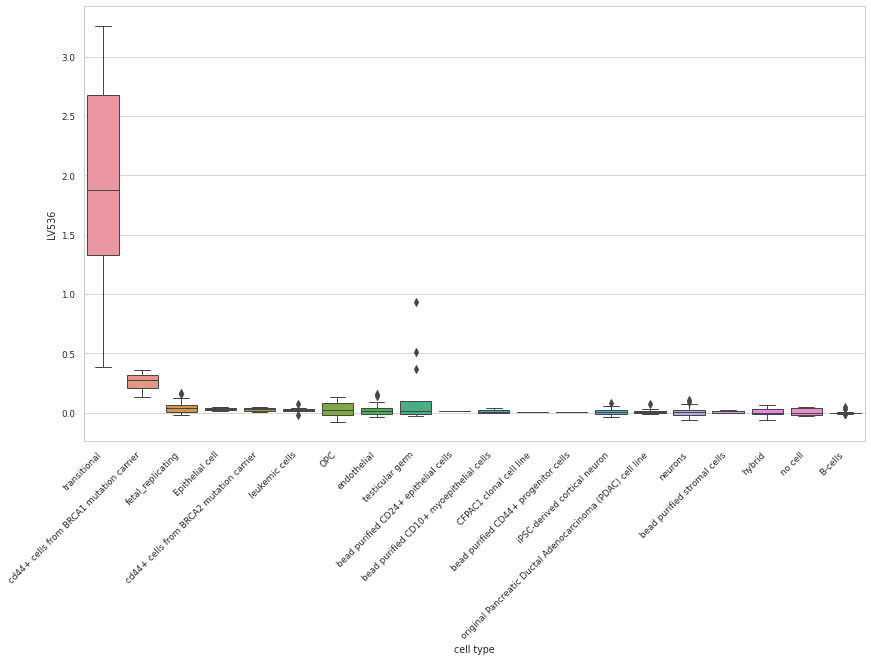

array(['SRP003901', 'SRP008218', 'SRP066834', 'SRP019994', 'SRP057196',
       'SRP005279', 'SRP002326', 'SRP017777', 'SRP055513', 'SRP042218'],
      dtype=object)

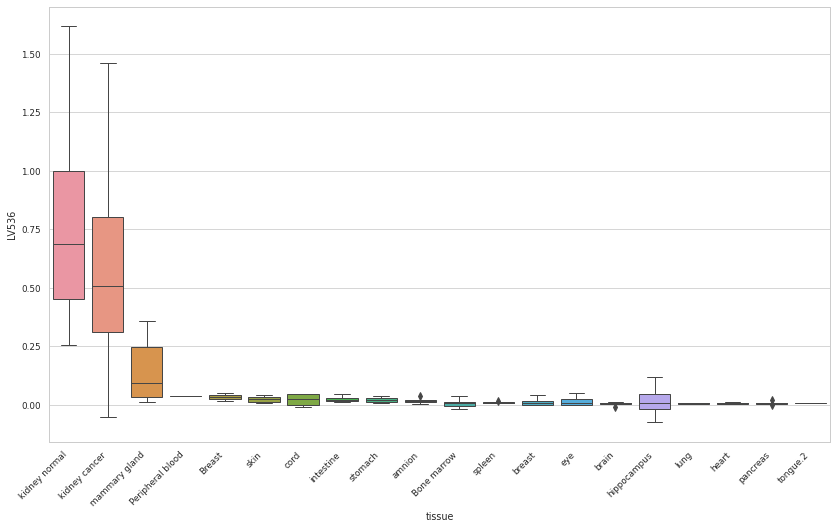

,pathway,LV index,AUC,p-value,FDR
244,SVM T cells follicular helper,50,0.695023,0.006173,0.031780
247,PID_NFAT_TFPATHWAY,50,0.722988,0.007294,0.036336


SRP060416, SRP007461, SRP056295, SRP057196, SRP055390, SRP005279, SRP050499, SRP003726, SRP028594, SRP043434, SRP033266, SRP058237, SRP008218, SRP045500, SRP032789, SRP041538, SRP048759, SRP021891, SRP064458, SRP043080, SRP042161, SRP063834, SRP055440, SRP056197, SRP018359, SRP050272, SRP063363, SRP027364, SRP043339, SRP004847, SRP059695, SRP035679, SRP041885, SRP021193, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (33 != 34)
  warnings.warn(


''

4105_raw-Heel_bone_mineral_density_BMD_left                                                                                                                  4.608126
4104_raw-Heel_quantitative_ultrasound_index_QUI_direct_entry_left                                                                                            4.237814
4106_raw-Heel_bone_mineral_density_BMD_Tscore_automated_left                                                                                                 4.237439
4101_raw-Heel_broadband_ultrasound_attenuation_left                                                                                                          4.196054
20513-Recent_thoughts_of_suicide_or_selfharm                                                                                                                 3.938136
22601_62142638-Job_coding_air_travel_assistant_cabinflight_attendant_air_hostess_air_purser_air_steward_cabin_crew_passenger_services_agent_checkin_staff    3.676860
2261

''

,gene_name,LV50,gene_band
0,JUN,5.212525,1p32.1
1,JUNB,4.817316,19p13.13
2,FOSB,4.644053,19q13.32
3,FOS,4.605874,14q24.3
4,ZFP36,4.059839,19q13.2
5,DUSP1,3.480934,5q35.1
6,ATF3,3.309229,1q32.3
7,PPP1R15A,3.243550,19q13.33
8,JUND,3.017858,19p13.11
9,KLF6,2.971206,10p15.2


cell type    0.020994
tissue       0.017738
dtype: float64

array(['SRP060416', 'SRP056295', 'SRP057196', 'SRP055390', 'SRP005279',
       'SRP003726', 'SRP033266', 'SRP058237', 'SRP008218', 'SRP048759',
       'SRP043080', 'SRP042161', 'SRP063834', 'SRP056197', 'SRP018359',
       'SRP063363', 'SRP004847', 'SRP059695', 'SRP041885'], dtype=object)

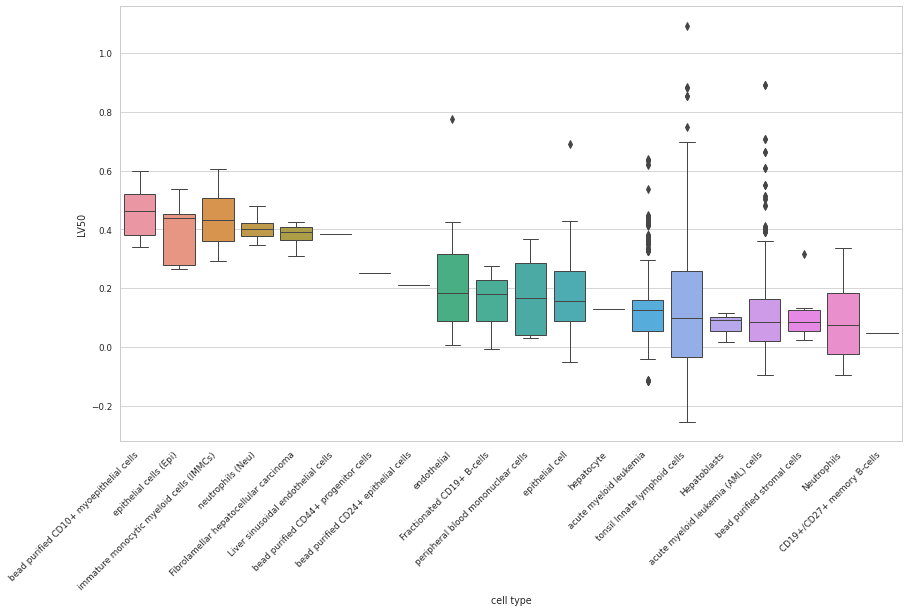

array(['SRP056295', 'SRP057196', 'SRP055390', 'SRP005279', 'SRP003726',
       'SRP028594', 'SRP043434', 'SRP033266', 'SRP058237', 'SRP008218',
       'SRP041538', 'SRP048759', 'SRP021891', 'SRP056197', 'SRP063363',
       'SRP027364', 'SRP043339', 'SRP004847', 'SRP021193'], dtype=object)

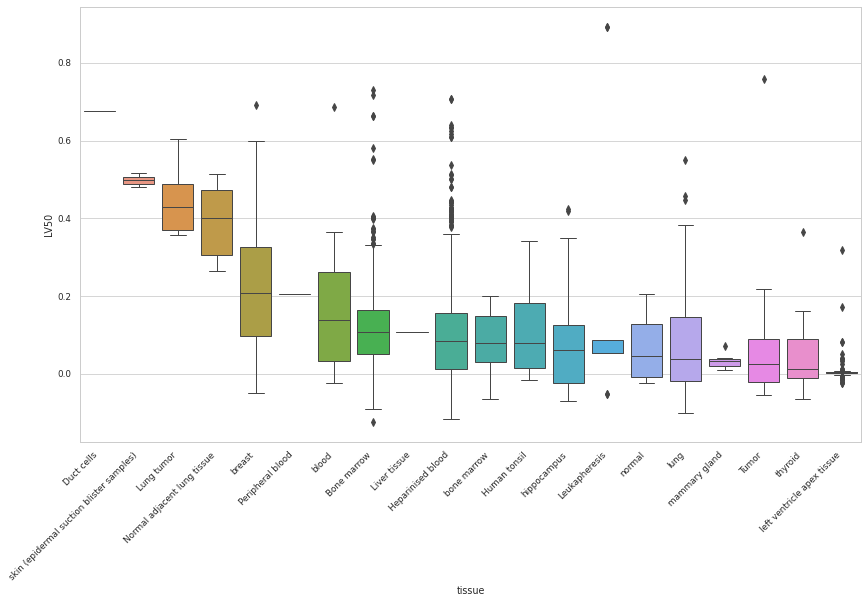

,pathway,LV index,AUC,p-value,FDR
1672,REACTOME_PEPTIDE_CHAIN_ELONGATION,707,0.999766,1.032655e-15,1.012472e-13
1673,KEGG_RIBOSOME,707,0.956636,2.047765e-13,1.472343e-11
1674,MIPS_40S_RIBOSOMAL_SUBUNIT_CYTOPLASMIC,707,0.997768,6.831719e-07,1.351928e-05
1675,MIPS_RIBOSOME_CYTOPLASMIC,707,0.999530,7.948872e-15,7.144049e-13
1676,REACTOME_ACTIVATION_OF_THE_MRNA_UPON_BINDING_O...,707,0.864580,8.299737e-07,1.612841e-05


SRP036821, SRP006575, SRP050499, SRP056049, SRP003227, SRP051102, SRP055569, SRP014428, SRP023262, SRP055675, SRP042161, SRP006475, SRP005279, SRP042616, SRP007359, SRP018525, SRP051765, SRP050215, SRP036053, SRP011546, SRP068523, SRP033369, SRP059057, SRP049063, SRP048971, SRP019994, SRP045898, SRP034543, SRP018838, SRP014867, SRP005177, SRP055390, SRP037735, SRP009067, SRP042218, SRP028594, SRP012461, SRP029452, SRP014146, SRP058977, SRP033135, SRP014739, SRP008976, SRP062025, SRP001563, SRP046233, SRP035599, SRP056295, SRP058840, SRP057250, SRP058120, SRP034712, SRP060715, SRP057745, SRP057244, SRP053046, SRP029739, SRP022920, SRP009266, SRP057852, SRP001540, SRP045869, SRP058046, SRP065988, SRP067214, SRP059775, SRP042043, SRP058841, SRP049648, SRP019222, SRP067661, SRP004847, SRP044206, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (72 != 73)
  warnings.warn(


''

20003_1140861806-Treatmentmedication_code_aspirin_75mg_tablet                                                               3.508411
22601_24213281-Job_coding_charteredcertified_accountant_auditor_company_accountant_articledaudit_clerk_official_receiver    3.402996
22617_2421-Job_SOC_coding_Chartered_and_certified_accountants                                                               3.319470
anal neoplasm                                                                                                               3.162123
DM_RETINOPAT_NOS-Unclassified_diabetic_retinopathy                                                                          3.031774
2654_5-Nonbutter_spread_type_details_Hard_block_margarine                                                                   2.965024
20003_1140922714-Treatmentmedication_code_dorzolamide                                                                       2.944282
20552_2-Behavioural_and_miscellaneous_addictions_A_behaviour         

''

,gene_name,LV707,gene_band
0,RPL26,4.806982,17p13.1
1,RPS4X,4.751073,NaN
2,RPS18,4.703236,6p21.32
3,RPS10,4.641886,6p21.31
4,RPL27A,4.599172,11p15.4
5,RPL24,4.574992,3q12.3
6,RPS14,4.521517,5q33.1
7,RPL31,4.513816,2q11.2
8,RPS19,4.489249,19q13.2
9,RPS5,4.444449,19q13.43


tissue subtype    0.057628
tissue            0.016806
cell type         0.015001
cell line/type    0.014849
cell phenotype    0.008755
dtype: float64

array(['SRP036821'], dtype=object)

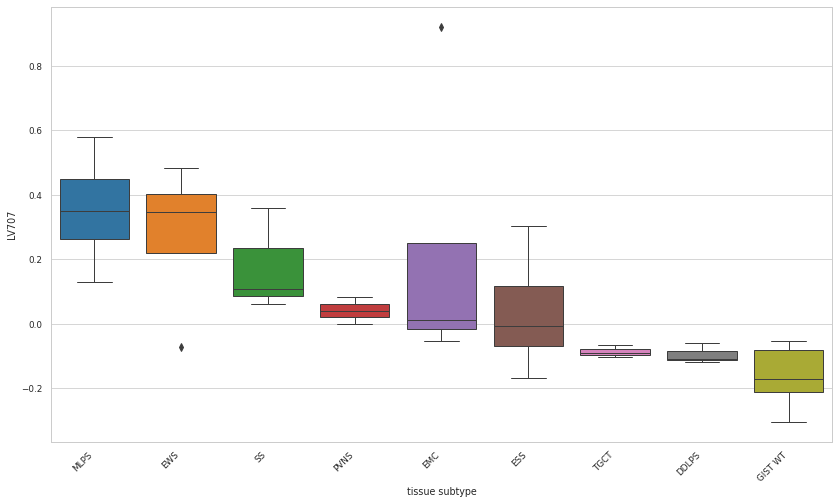

array(['SRP036821', 'SRP006575', 'SRP014428', 'SRP023262', 'SRP005279',
       'SRP007359', 'SRP036053', 'SRP011546', 'SRP049063', 'SRP019994',
       'SRP045898', 'SRP055390', 'SRP042218', 'SRP028594', 'SRP029452',
       'SRP014146', 'SRP014739', 'SRP062025', 'SRP056295', 'SRP045869',
       'SRP067661', 'SRP004847'], dtype=object)

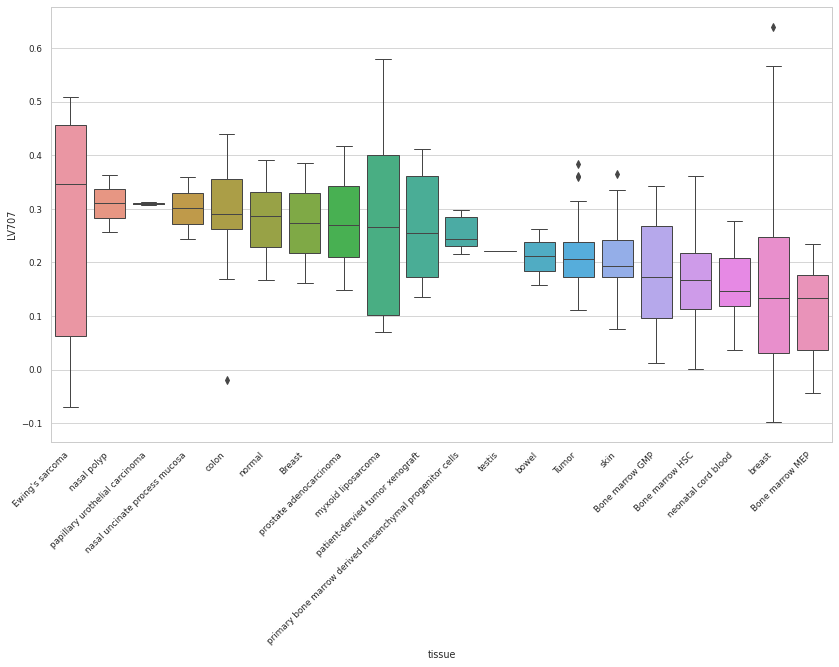

array(['SRP006575', 'SRP003227', 'SRP051102', 'SRP055569', 'SRP014428',
       'SRP055675', 'SRP042161', 'SRP005279', 'SRP018525', 'SRP051765',
       'SRP011546', 'SRP068523', 'SRP049063', 'SRP048971', 'SRP034543',
       'SRP055390', 'SRP037735', 'SRP009067', 'SRP042218', 'SRP012461',
       'SRP033135', 'SRP008976', 'SRP046233', 'SRP035599', 'SRP056295',
       'SRP060715', 'SRP053046', 'SRP022920', 'SRP057852', 'SRP058046',
       'SRP065988', 'SRP067661', 'SRP004847', 'SRP044206'], dtype=object)

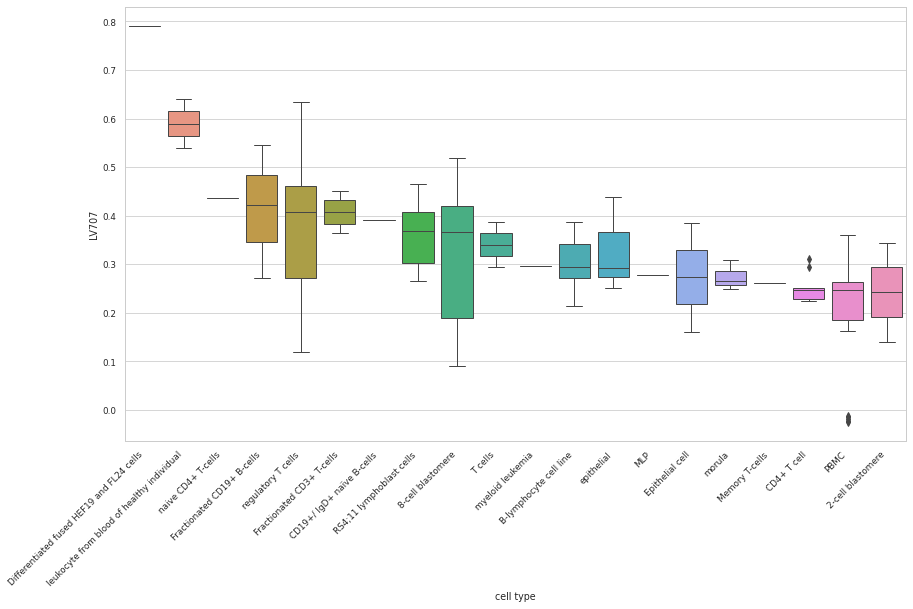

array(['SRP058120'], dtype=object)

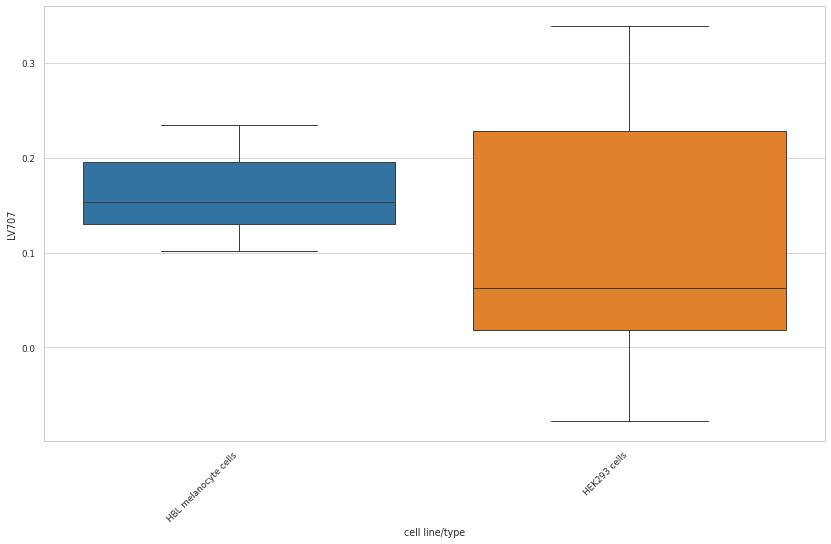

array(['SRP062025'], dtype=object)

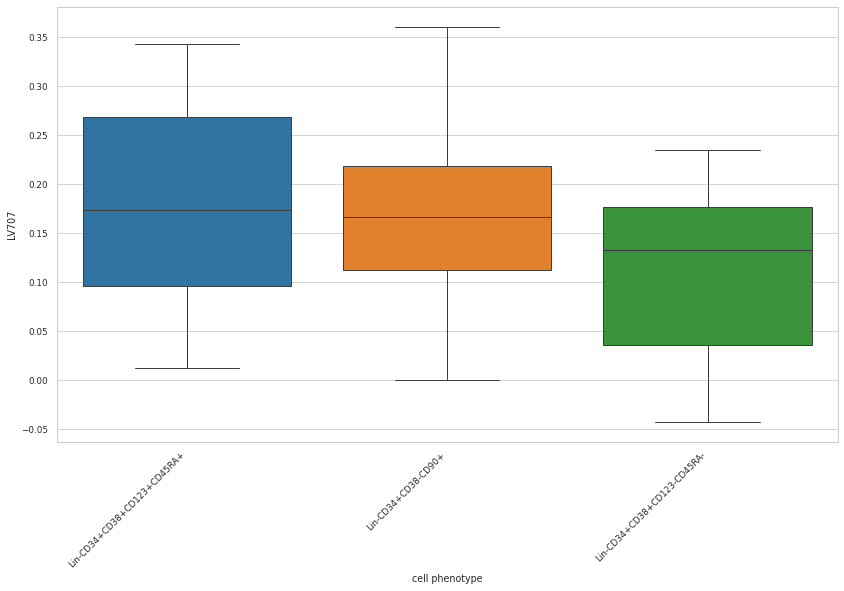

,pathway,LV index,AUC,p-value,FDR


SRP004847, SRP004965, SRP008218, SRP003726, SRP009266, SRP057196, SRP002915, SRP005279, SRP055569, SRP032789, SRP042161, SRP055513, SRP026042, SRP057244, SRP050954, SRP041538, SRP066834, SRP007461, SRP012461, SRP023262, SRP032833, SRP014790, SRP017575, SRP064464, SRP029262, SRP060416, SRP065202, SRP012099, SRP042218, SRP042620, SRP022920, SRP036821, SRP012656, SRP022591, SRP056733, SRP014670, SRP036053, SRP056098, SRP024268, SRP055390, SRP064458, SRP058722, SRP058773, SRP033135, SRP029592, SRP012557, SRP040998, SRP050499, SRP059379, SRP057205, SRP031776, SRP061426, SRP049097, SRP010678, SRP002628, SRP059057, SRP009251, SRP019994, SRP063838, SRP046376, SRP050892, SRP049409, SRP028118, SRP003611, SRP027383, SRP043080, SRP017142, SRP006575, SRP007338, SRP027364, SRP065219, SRP029207, SRP014624, SRP017972, SRP052879, SRP039397, SRP016140, SRP026537, SRP050003, SRP013984, SRP036848, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (77 != 81)
  warnings.warn(


''

20110_100-Illnesses_of_mother_None_of_the_above_group_1                                                             4.150251
41248_7002-Destinations_on_discharge_from_hospital_recoded_Nursing_residential_care_group_home_Local_Authoritory    3.403445
E4_DM1NOCOMP-Type_1_diabetes_without_complications                                                                  3.306821
30210_raw-Eosinophill_percentage                                                                                    3.300717
20003_1140882394-Treatmentmedication_code_paracetamol_codeine                                                       3.282539
urinary incontinence                                                                                                3.190865
22640_1-Mixture_of_day_and_night_shifts_worked_Shift_pattern_was_worked_for_whole_of_job                            3.174324
peripheral nervous system disease                                                                                   3.024953


''

,gene_name,LV142,gene_band
0,CEBPB,6.918905,20q13.13
1,TSPYL2,4.931582,NaN
2,CEBPD,4.453014,8q11.21
3,CRISPLD2,3.958093,16q24.1
4,SLC1A5,3.780786,19q13.32
5,TRAF4,3.614911,17q11.2
6,ANGPTL4,3.527698,19p13.2
7,PI4K2A,3.508539,10q24.2
8,CFD,3.194959,19p13.3
9,CSF1,2.943755,1p13.3


tissue            0.060374
cell type         0.044663
tissue type       0.002685
tissue subtype    0.002503
dtype: float64

array(['SRP004847', 'SRP004965', 'SRP008218', 'SRP003726', 'SRP057196',
       'SRP005279', 'SRP055513', 'SRP026042', 'SRP041538', 'SRP066834',
       'SRP023262', 'SRP017575', 'SRP029262', 'SRP042218', 'SRP042620',
       'SRP036821', 'SRP014670', 'SRP036053', 'SRP024268', 'SRP055390',
       'SRP058722', 'SRP029592', 'SRP031776', 'SRP049097', 'SRP002628',
       'SRP009251', 'SRP019994', 'SRP063838', 'SRP006575', 'SRP027364',
       'SRP065219', 'SRP029207', 'SRP050003', 'SRP036848'], dtype=object)

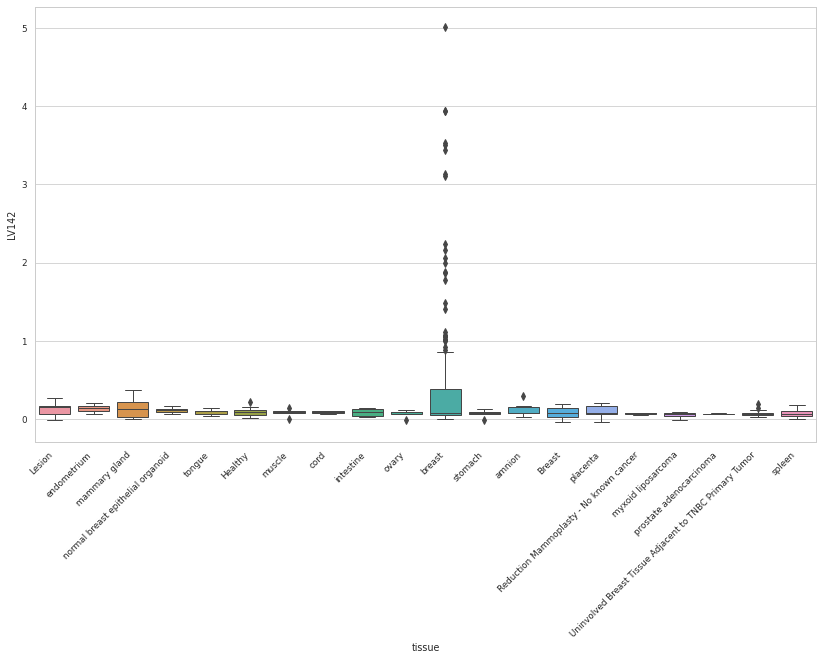

array(['SRP004847', 'SRP004965', 'SRP008218', 'SRP003726', 'SRP057196',
       'SRP005279', 'SRP055569', 'SRP042161', 'SRP050954', 'SRP012461',
       'SRP060416', 'SRP065202', 'SRP042218', 'SRP022920', 'SRP014670',
       'SRP055390', 'SRP033135', 'SRP059379', 'SRP061426', 'SRP010678',
       'SRP049409', 'SRP028118', 'SRP043080', 'SRP017142', 'SRP006575',
       'SRP052879', 'SRP016140', 'SRP026537', 'SRP050003'], dtype=object)

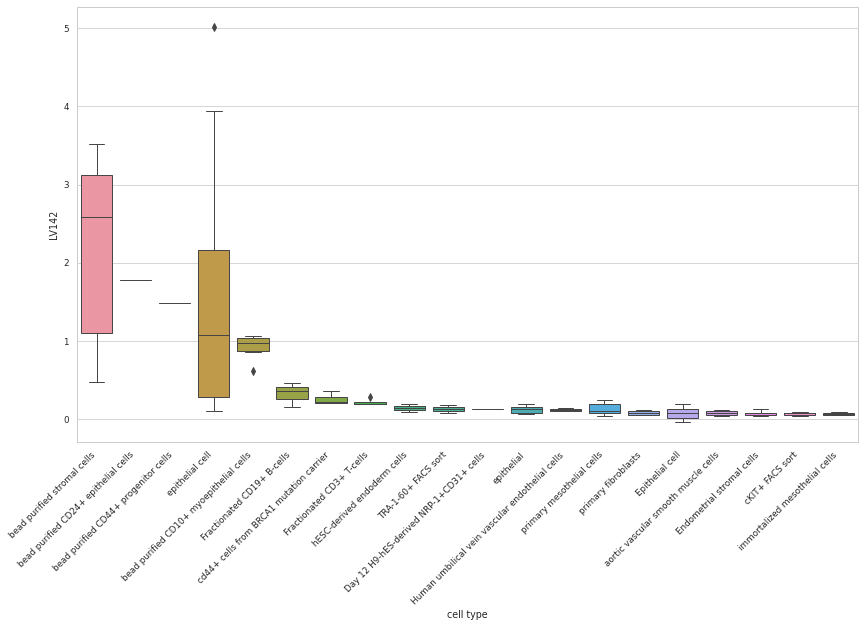

array(['SRP032833', 'SRP012656', 'SRP049097'], dtype=object)

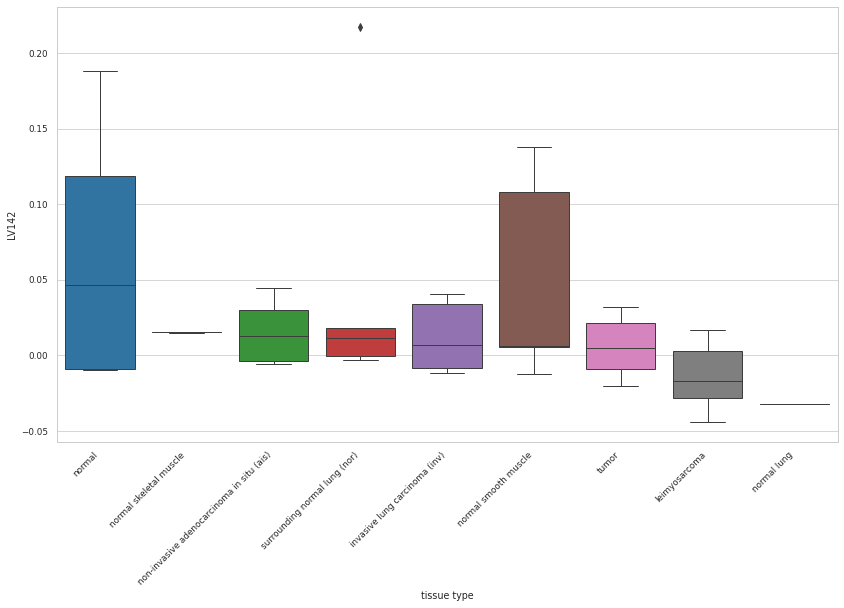

array(['SRP036821'], dtype=object)

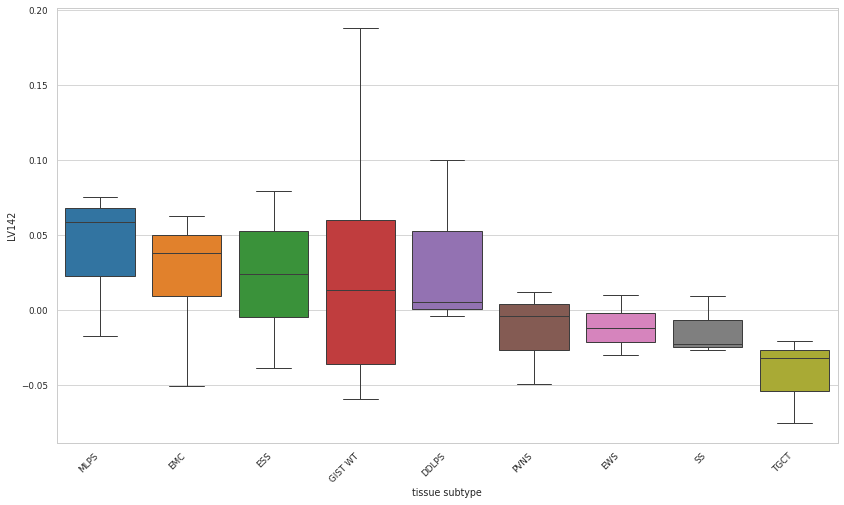

,pathway,LV index,AUC,p-value,FDR


SRP039077, SRP043388, SRP052856, SRP008496, SRP007169, SRP057586, SRP059275, SRP043694, SRP055569, SRP044206, SRP010678, SRP026333, SRP006575, SRP039552, SRP056637, SRP055513, SRP035641, SRP064259, SRP044925, SRP065812, SRP011974, SRP051182, SRP056330, SRP014739, SRP026042, SRP057196, SRP056840, SRP050000, SRP018853, SRP063840, SRP014320, SRP035988, SRP052615, SRP065763, SRP060416, SRP035864, SRP059732, SRP058722, SRP026537, SRP066834, SRP063661, SRP057087, SRP062188, SRP010166, SRP063496, SRP021917, SRP041094, SRP050440, SRP028822, SRP035391, SRP024274, SRP033135, SRP018883, SRP024268, SRP045898, SRP050499, SRP041751, SRP058773, SRP063834, SRP050971, SRP063493, SRP002326, SRP028180, SRP014146, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (63 != 64)
  warnings.warn(


''

1538_2-Major_dietary_changes_in_the_last_5_years_Yes_because_of_other_reasons                      3.813892
20113_9-Illnesses_of_adopted_mother_Diabetes                                                       3.618411
22601_62213359-Job_coding_hairdresser_barber_shampooist_hair_stylist                               3.588464
22601_21273045-Job_coding_production_and_process_engineer                                          3.434821
22617_6221-Job_SOC_coding_Hairdressers_barbers                                                     3.422579
cartilage disease                                                                                  3.340761
22607_0-Workplace_very_cold_Rarelynever                                                            3.174372
number of children fathered measurement                                                            3.160661
sexual dysfunction                                                                                 3.135292
placenta praevia            

''

,gene_name,LV95,gene_band
0,CSTA,6.911719,3q21.1
1,S100P,5.721709,4p16.1
2,MAL,5.453182,2q11.1
3,CSTB,3.843053,21q22.3
4,ANXA1,3.615306,9q21.13
5,PI3,3.251395,20q13.12
6,LGALS3,3.183449,14q22.3
7,GDPD3,3.148883,16p11.2
8,MYO5B,2.872883,18q21.1
9,SLK,2.815702,10q24.33


cell type       0.056136
tissue type     0.007463
tissue          0.005297
cell subtype    0.005169
dtype: float64

array(['SRP039077', 'SRP007169', 'SRP055569', 'SRP044206', 'SRP010678',
       'SRP006575', 'SRP039552', 'SRP056637', 'SRP035641', 'SRP064259',
       'SRP044925', 'SRP056330', 'SRP057196', 'SRP063840', 'SRP060416',
       'SRP026537', 'SRP062188', 'SRP010166', 'SRP041094', 'SRP024274',
       'SRP033135', 'SRP041751', 'SRP063834', 'SRP028180'], dtype=object)

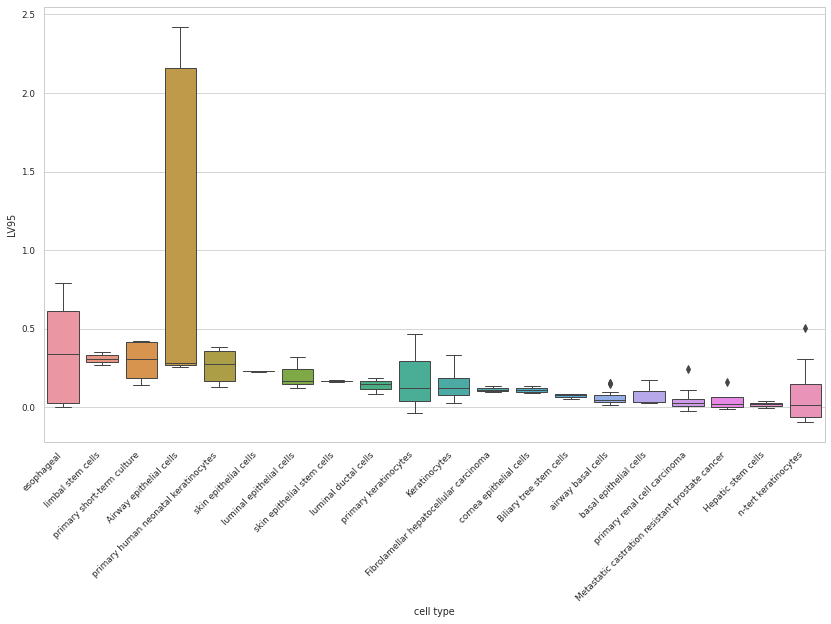

array(['SRP007169', 'SRP065812', 'SRP035988', 'SRP050971'], dtype=object)

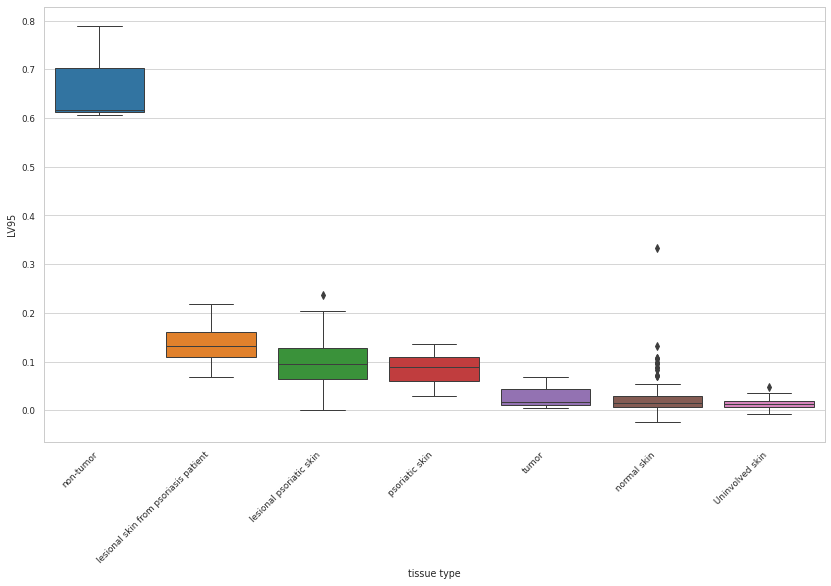

array(['SRP008496', 'SRP059275', 'SRP026333', 'SRP006575', 'SRP055513',
       'SRP056330', 'SRP014739', 'SRP026042', 'SRP057196', 'SRP052615',
       'SRP035864', 'SRP058722', 'SRP066834', 'SRP063496', 'SRP024268',
       'SRP045898', 'SRP002326', 'SRP028180', 'SRP014146'], dtype=object)

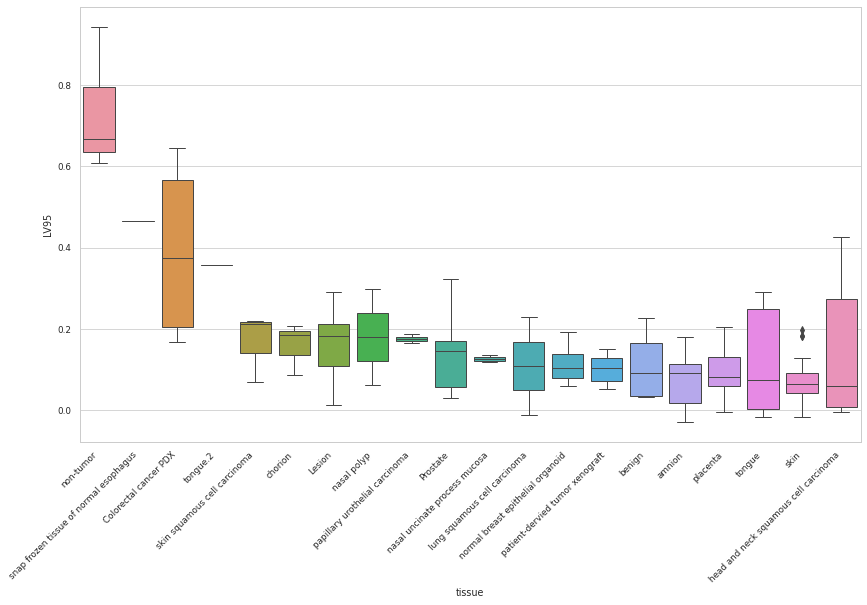

array(['SRP063661'], dtype=object)

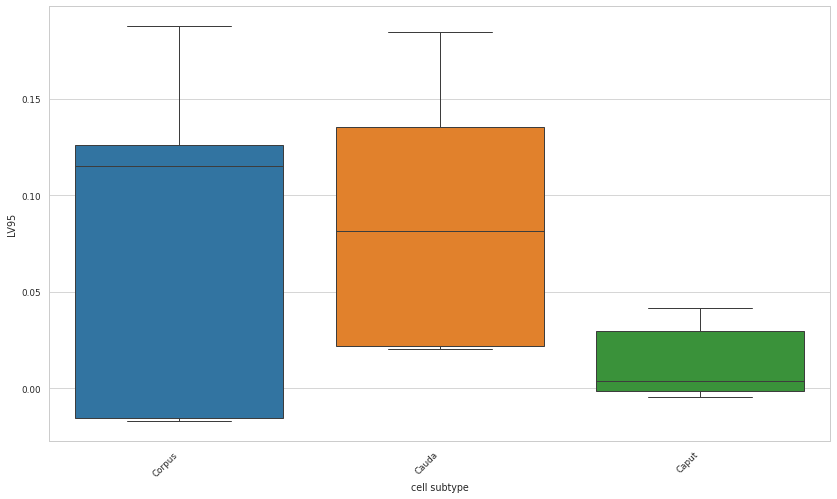

,pathway,LV index,AUC,p-value,FDR
423,KEGG_METABOLISM_OF_XENOBIOTICS_BY_CYTOCHROME_P450,97,0.789912,0.004579,0.025007
425,KEGG_ARACHIDONIC_ACID_METABOLISM,97,0.807307,0.000546,0.004587


SRP049988, SRP007461, SRP009862, SRP063658, SRP012557, SRP009790, SRP067836, SRP039397, SRP055860, SRP014920, SRP017019, SRP009266, SRP055153, SRP064464, SRP028902, SRP043960, SRP041228, SRP011578, SRP013935, SRP067934, SRP055863, SRP052950, SRP055569, SRP010907, SRP064259, SRP014027, SRP040998, SRP050087, SRP009123, SRP063834, SRP017411, SRP050003, SRP045048, SRP040692, SRP010166, SRP058626, SRP019240, SRP064321, SRP051544, SRP051606, SRP057248, SRP063620, SRP022876, SRP035387, SRP051485, SRP066956, SRP061701, SRP015845, SRP012461, SRP050551, SRP045659, SRP057196, SRP003901, SRP029262, SRP056696, SRP014190, SRP050497, SRP065491, SRP042620, SRP042184, SRP050440, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (56 != 61)
  warnings.warn(


''

20015_raw-Sitting_height                                                                                               3.804068
20110_5-Illnesses_of_mother_Breast_cancer                                                                              3.542450
20003_1140911640-Treatmentmedication_code_lecithin_product                                                             3.306934
20550_3-Activities_undertaken_to_treat_anxiety_Other_therapeutic_activities_such_as_mindfulness_yoga_or_art_classes    3.086596
M13_THORACISPINEPAIN-Pain_in_thoracic_spine                                                                            3.056867
AB1_OTHER_BACTERIAL-Other_bacterial_diseases                                                                           3.039800
22640_1-Mixture_of_day_and_night_shifts_worked_Shift_pattern_was_worked_for_whole_of_job                               3.036236
20003_1141200322-Treatmentmedication_code_solifenacin                                                   

''

,gene_name,LV97,gene_band
0,ALDH1A1,6.027473,9q21.13
1,AKR1C3,5.937320,10p15.1
2,ABCC2,4.590391,10q24.2
3,G6PD,3.896312,NaN
4,AKR1C2,3.604203,10p15.1
5,ABCC3,3.207776,17q21.33
6,CYP24A1,3.014617,20q13.2
7,TXNRD1,2.720542,12q23.3
8,SQSTM1,2.568242,5q35.3
9,AKR1C1,2.490479,10p15.1


cell type    0.048794
tissue       0.012782
dtype: float64

array(['SRP049988', 'SRP067836', 'SRP055860', 'SRP017019', 'SRP055153',
       'SRP028902', 'SRP041228', 'SRP011578', 'SRP013935', 'SRP055569',
       'SRP064259', 'SRP014027', 'SRP063834', 'SRP017411', 'SRP050003',
       'SRP045048', 'SRP040692', 'SRP010166', 'SRP058626', 'SRP019240',
       'SRP064321', 'SRP051544', 'SRP051606', 'SRP063620', 'SRP022876',
       'SRP035387', 'SRP012461', 'SRP057196'], dtype=object)

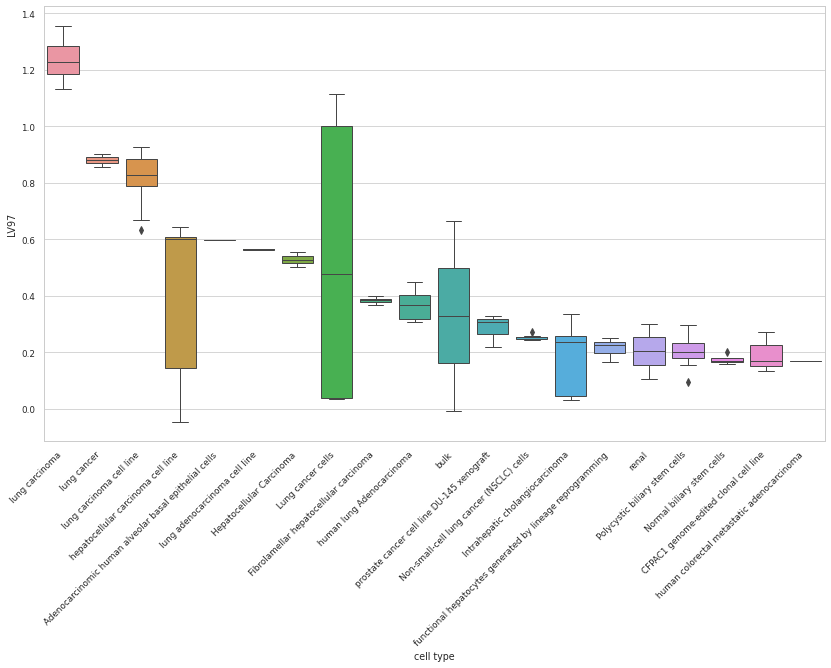

array(['SRP067934', 'SRP055863', 'SRP052950', 'SRP050087', 'SRP009123',
       'SRP050003', 'SRP040692', 'SRP058626', 'SRP050551', 'SRP057196',
       'SRP003901', 'SRP029262', 'SRP056696', 'SRP042620'], dtype=object)

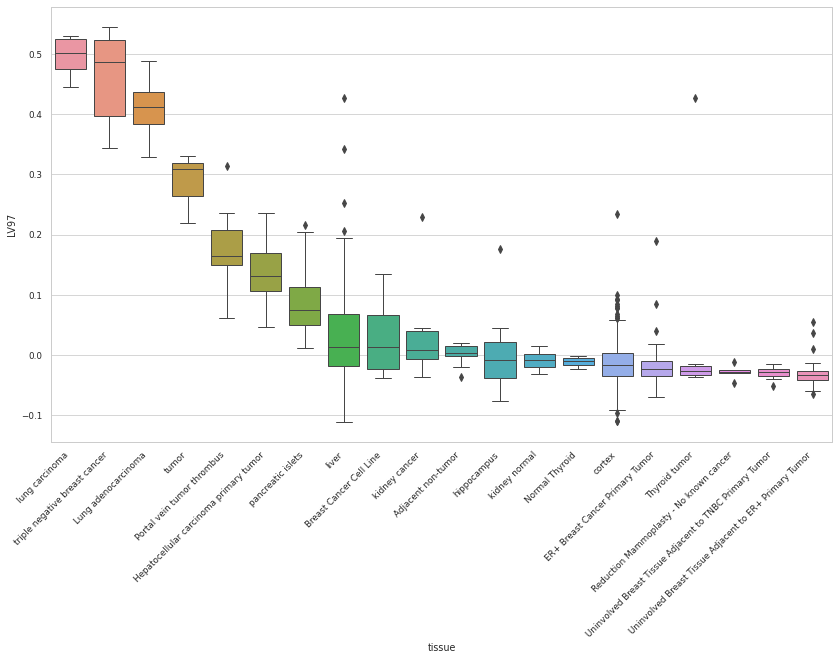

,pathway,LV index,AUC,p-value,FDR
353,REACTOME_DIABETES_PATHWAYS,74,0.873715,4.238590e-10,1.451212e-08
354,REACTOME_UNFOLDED_PROTEIN_RESPONSE,74,0.837176,3.084042e-06,5.078076e-05
355,REACTOME_ASPARAGINE_N_LINKED_GLYCOSYLATION,74,0.761173,1.448117e-04,1.516753e-03


SRP010038, SRP043166, SRP042161, SRP006970, SRP066834, SRP064323, SRP042249, SRP055569, SRP041825, SRP057196, SRP049988, SRP024274, SRP059035, SRP014428, SRP063840, SRP016059, SRP007596, SRP047082, SRP050179, SRP029262, SRP033135, SRP060416, SRP060355, SRP026042, SRP048562, SRP064464, SRP056498, SRP019241, SRP013022, SRP009266, SRP064259, SRP041751, SRP056530, SRP050499, SRP067701, SRP017435, SRP041846, SRP004637, SRP061329, SRP061682, SRP042620, SRP020491, SRP059379, SRP020493, SRP035391, SRP033393, SRP025989, SRP050892, SRP032812, SRP007461, SRP045711, SRP042616, SRP018218, SRP057205, SRP049591, SRP033078, SRP058740, SRP022166, SRP055863, SRP011895, SRP045639, SRP021509, SRP045859, SRP056220, SRP041036, SRP027383, SRP051705, SRP058783, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (66 != 68)
  warnings.warn(


''

discitis                                                                                                                    3.614737
C48-Diagnoses_main_ICD10_C48_Malignant_neoplasm_of_retroperitoneum_and_peritoneum                                           3.506715
22617_8138-Job_SOC_coding_Routine_laboratory_testers                                                                        3.402239
20110_101-Illnesses_of_mother_None_of_the_above_group_2                                                                     3.392368
20084_474-Vitamin_andor_mineral_supplement_use_Evening_primrose_                                                            3.352129
22617_6121-Job_SOC_coding_Nursery_nurses                                                                                    3.240579
20003_1140888560-Treatmentmedication_code_perindopril                                                                       3.203299
20003_1140865354-Treatmentmedication_code_gaviscon_liquid            

''

,gene_name,LV74,gene_band
0,HSPA5,4.958830,9q33.3
1,HYOU1,3.826483,11q23.3
2,HSP90B1,3.751964,12q23.3
3,DNAJB9,3.109571,7q31.1
4,HERPUD1,2.736264,16q13
5,DDIT3,2.712314,12q13.3
6,DNAJC3,2.666935,13q32.1
7,PDIA6,2.530785,2p25.1
8,SEC31A,2.463485,4q21.22
9,SSR1,2.223638,6p24.3


cell type    0.014749
tissue       0.014416
dtype: float64

array(['SRP010038', 'SRP042161', 'SRP006970', 'SRP042249', 'SRP055569',
       'SRP041825', 'SRP057196', 'SRP049988', 'SRP024274', 'SRP059035',
       'SRP014428', 'SRP063840', 'SRP016059', 'SRP007596', 'SRP047082',
       'SRP050179', 'SRP033135', 'SRP060416', 'SRP056498', 'SRP019241',
       'SRP013022', 'SRP064259', 'SRP041751', 'SRP067701', 'SRP041846',
       'SRP061682', 'SRP020491', 'SRP059379', 'SRP020493', 'SRP033393',
       'SRP045711', 'SRP018218', 'SRP033078', 'SRP045639', 'SRP021509',
       'SRP045859', 'SRP056220'], dtype=object)

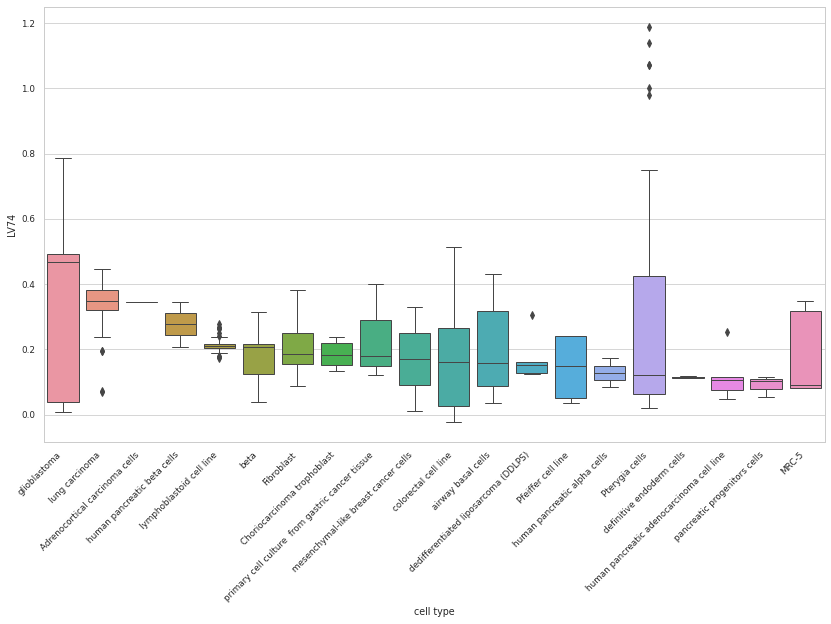

array(['SRP043166', 'SRP066834', 'SRP064323', 'SRP057196', 'SRP014428',
       'SRP016059', 'SRP029262', 'SRP060355', 'SRP026042', 'SRP004637',
       'SRP042620', 'SRP032812', 'SRP058740', 'SRP055863'], dtype=object)

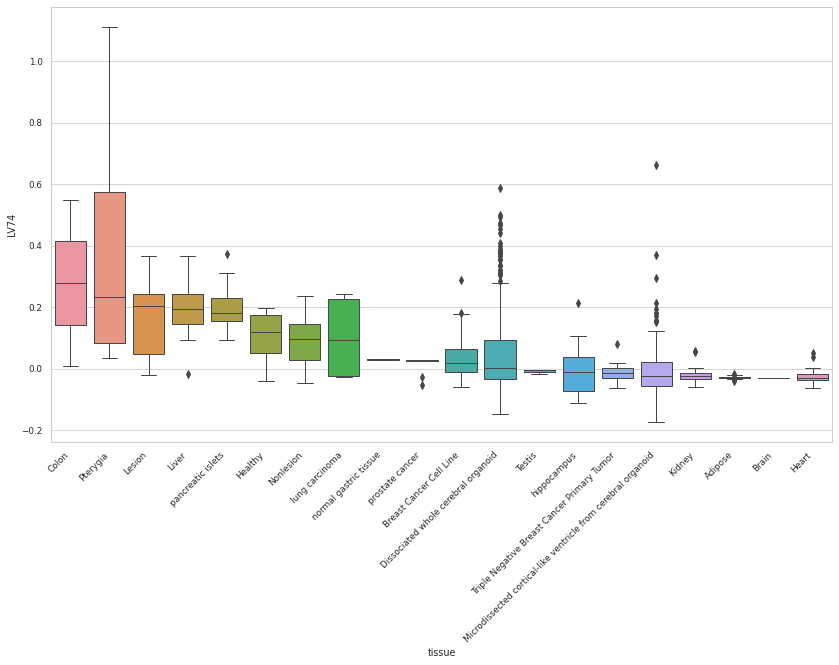

,pathway,LV index,AUC,p-value,FDR
316,REACTOME_METABOLISM_OF_LIPIDS_AND_LIPOPROTEINS,66,0.615625,0.000024,0.000312


SRP048674, SRP029207, SRP021912, SRP051249, SRP040292, SRP055513, SRP055569, SRP057196, SRP050499, SRP017959, SRP029334, SRP045364, SRP043434, SRP049981, SRP042161, SRP008218, SRP020646, SRP011895, SRP012461, SRP021193, SRP012656, SRP026052, SRP050954, SRP037982, SRP049946, SRP027383, SRP022259, SRP049409, SRP056696, SRP018933, SRP002915, SRP033135, SRP009123, SRP058804, SRP043221, SRP066834, SRP050193, SRP048759, SRP047192, SRP050551, SRP008145, SRP060416, SRP044610, SRP050992, SRP004637, SRP044668, SRP057205, SRP058773, SRP042218, SRP016059, SRP058740, SRP040300, SRP020493, SRP039694, SRP040998, SRP058375, SRP056146, SRP010054, SRP039591, SRP019994, SRP014790, SRP014213, SRP007338, SRP029262, SRP014809, SRP018403, SRP041538, SRP063834, SRP034592, SRP018838, SRP007494, SRP050374, SRP002326, SRP007481, SRP030617, SRP026620, SRP052879, SRP015013, SRP033351, SRP058626, SRP061566, SRP039338, SRP017435, SRP044042, SRP015853, SRP007461, SRP007498, SRP003726, SRP066371, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (86 != 89)
  warnings.warn(


''

L12_HYPERTROPHICNAS-Other_and_unspecified_hypertrophic_disorders_of_skin                                                                                                      4.462269
L12_HYPERTROPHICSKIN-Hypertrophic_disorders_of_skin                                                                                                                           4.072287
100630-Rose_wine_intake                                                                                                                                                       3.963270
102360-Sweet_biscuits_intake                                                                                                                                                  3.868189
22601_62213359-Job_coding_hairdresser_barber_shampooist_hair_stylist                                                                                                          3.389067
22601_32293082-Job_coding_other_therapist_including_acupuncturist_aromatherapist_diet

''

,gene_name,LV66,gene_band
0,DHCR24,7.216010,1p32.3
1,SLC47A1,6.877400,17p11.2
2,HSD11B1,5.555764,1q32.2
3,SCARB1,5.109801,12q24.31
4,IL6ST,4.310095,5q11.2
5,DPYSL3,3.964287,5q32
6,PORCN,3.641519,NaN
7,PRKX,3.640764,NaN
8,RHOU,3.382568,1q42.13
9,GREB1,3.309886,2p25.1


cell type      0.049005
tissue         0.008016
tissue type    0.000788
dtype: float64

array(['SRP048674', 'SRP021912', 'SRP055569', 'SRP057196', 'SRP045364',
       'SRP049981', 'SRP042161', 'SRP008218', 'SRP012461', 'SRP050954',
       'SRP022259', 'SRP049409', 'SRP018933', 'SRP033135', 'SRP058804',
       'SRP048759', 'SRP047192', 'SRP060416', 'SRP044610', 'SRP050992',
       'SRP042218', 'SRP016059', 'SRP020493', 'SRP056146', 'SRP014213',
       'SRP063834', 'SRP007494', 'SRP050374', 'SRP026620', 'SRP052879',
       'SRP033351', 'SRP058626', 'SRP061566', 'SRP015853', 'SRP003726',
       'SRP066371'], dtype=object)

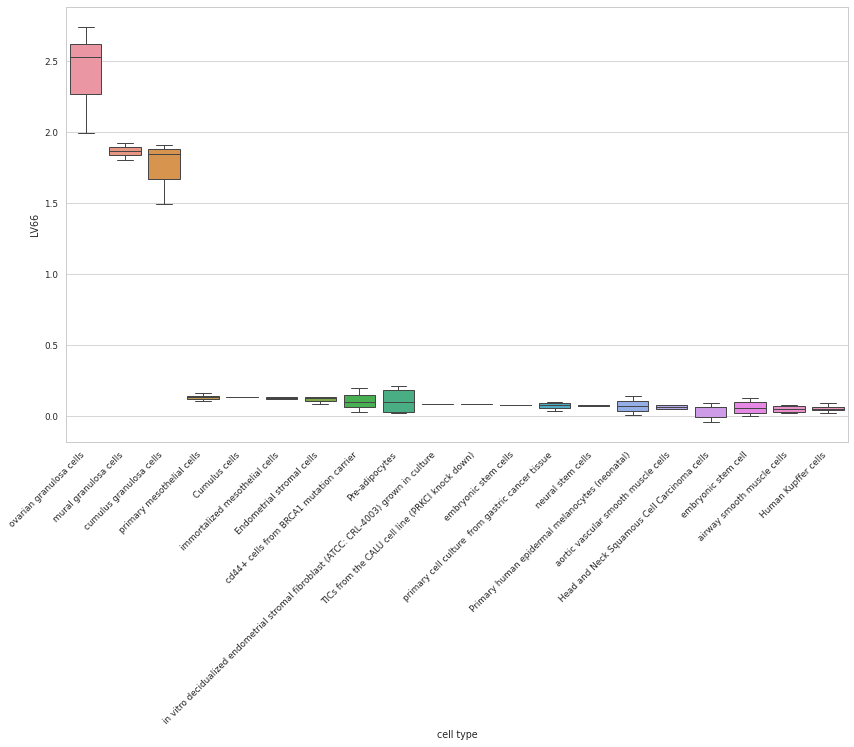

array(['SRP029207', 'SRP040292', 'SRP055513', 'SRP057196', 'SRP043434',
       'SRP008218', 'SRP021193', 'SRP037982', 'SRP056696', 'SRP018933',
       'SRP009123', 'SRP043221', 'SRP066834', 'SRP048759', 'SRP047192',
       'SRP050551', 'SRP004637', 'SRP042218', 'SRP016059', 'SRP058740',
       'SRP039694', 'SRP039591', 'SRP019994', 'SRP029262', 'SRP041538',
       'SRP034592', 'SRP007494', 'SRP002326', 'SRP007481', 'SRP033351',
       'SRP058626', 'SRP039338', 'SRP003726'], dtype=object)

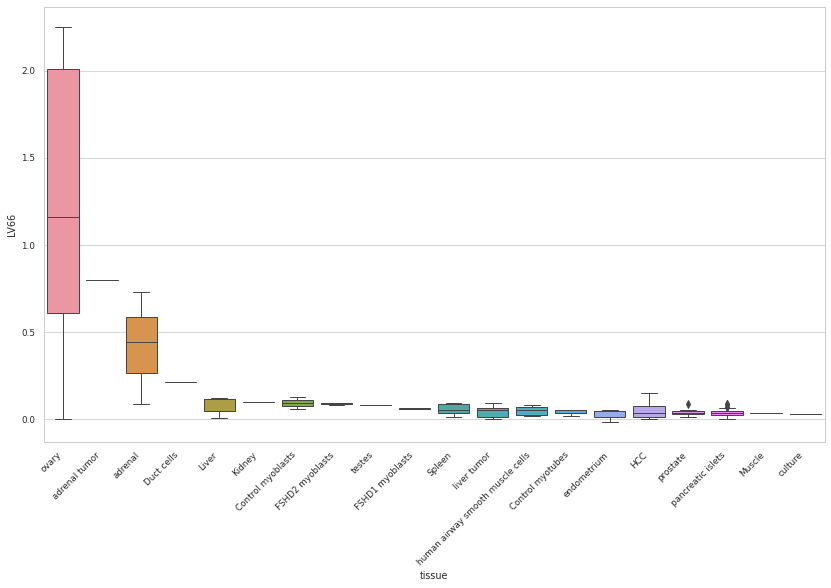

array(['SRP012656', 'SRP044668'], dtype=object)

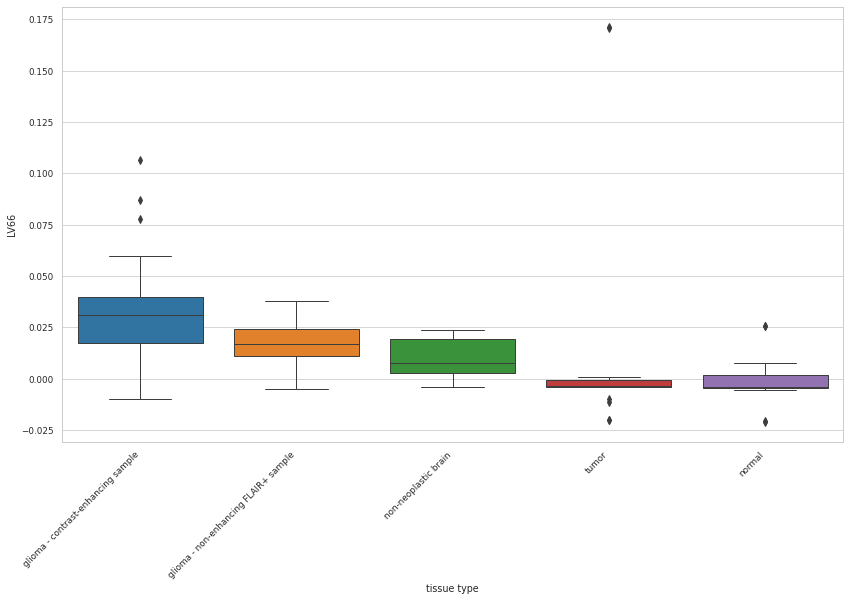

,pathway,LV index,AUC,p-value,FDR


SRP012098, SRP012099, SRP039397, SRP014591, SRP007498, SRP028887, SRP017411, SRP041130, SRP057804, SRP046271, SRP002326, SRP021214, SRP022892, SRP023111, SRP007461, SRP033135, SRP062389, SRP055153, SRP055569, SRP045222, SRP015976, SRP007946, SRP051102, SRP043593, SRP067214, SRP017294, SRP033119, SRP018861, SRP060416, SRP014688, SRP044298, SRP044611, SRP015711, SRP010907, SRP012546, SRP057196, SRP034601, SRP053195, SRP012557, SRP026052, SRP056696, SRP050499, SRP029889, SRP011974, SRP049611, SRP026537, SRP008331, SRP015370, SRP041956, SRP013463, SRP022591, SRP067934, SRP010054, SRP007412, SRP030639, SRP061455, SRP022876, SRP013363, SRP042161, SRP059066, SRP056084, SRP059948, SRP026084, SRP042620, SRP028902, SRP015715, SRP014790, SRP058571, SRP002789, SRP003672, SRP006474, SRP014857, SRP002487, SRP017644, SRP014809, SRP045663, SRP057814, SRP005342, SRP064464, SRP059205, SRP005279, SRP050003, SRP058435, SRP064561, SRP009790, SRP065500, SRP013239, SRP045155, SRP002079, SRP052879, SRP019946,

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (101 != 103)
  warnings.warn(


''

30100_raw-Mean_platelet_thrombocyte_volume                                                                                    4.022686
6072_7-OCT_measured_left_Not_performed_other_reason                                                                           3.427496
6070_7-OCT_measured_right_Not_performed_other_reason                                                                          3.417317
22601_91392859-Job_coding_other_work_in_these_industries_attendant_hand_mate_assistant_handler_loader                         3.325174
3143_raw-Ankle_spacing_width                                                                                                  3.314812
1349-Processed_meat_intake                                                                                                    3.220111
I9_ARTOTH-Other_diseases_of_arteries_and_capillaries                                                                          3.198999
30200_raw-Neutrophill_percentage                       

''

,gene_name,LV974,gene_band
0,EPPK1,4.297309,8q24.3
1,SMAD6,2.720874,15q22.31
2,GEMIN4,2.314724,17p13.3
3,SLC7A5,2.222809,16q24.2
4,CENPB,2.215286,20p13
5,B3GALT6,1.956991,1p36.33
6,HEXIM1,1.807730,17q21.31
7,DAG1,1.772852,3p21.31
8,MED26,1.711600,19p13.11
9,PC,1.638283,11q13.2


cell type    0.006419
tissue       0.006057
dtype: float64

array(['SRP017411', 'SRP057804', 'SRP021214', 'SRP033135', 'SRP055153',
       'SRP055569', 'SRP015976', 'SRP007946', 'SRP051102', 'SRP060416',
       'SRP014688', 'SRP044611', 'SRP057196', 'SRP034601', 'SRP049611',
       'SRP026537', 'SRP041956', 'SRP061455', 'SRP022876', 'SRP042161',
       'SRP059066', 'SRP056084', 'SRP028902', 'SRP015715', 'SRP058571',
       'SRP002789', 'SRP017644', 'SRP045663', 'SRP057814', 'SRP059205',
       'SRP005279', 'SRP050003', 'SRP058435', 'SRP064561', 'SRP052879',
       'SRP055860', 'SRP064562'], dtype=object)

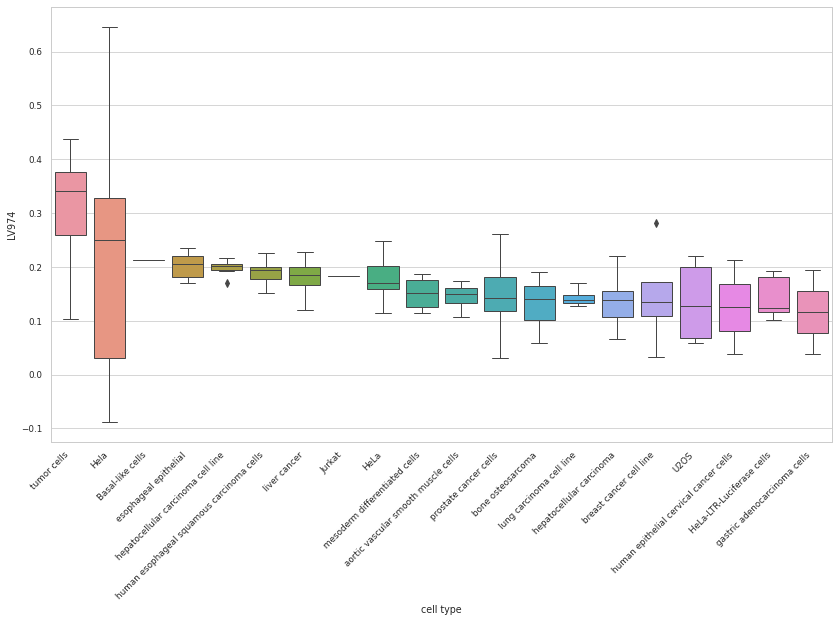

array(['SRP002326', 'SRP012546', 'SRP057196', 'SRP056696', 'SRP029889',
       'SRP067934', 'SRP030639', 'SRP042620', 'SRP005279', 'SRP050003',
       'SRP041387', 'SRP004637'], dtype=object)

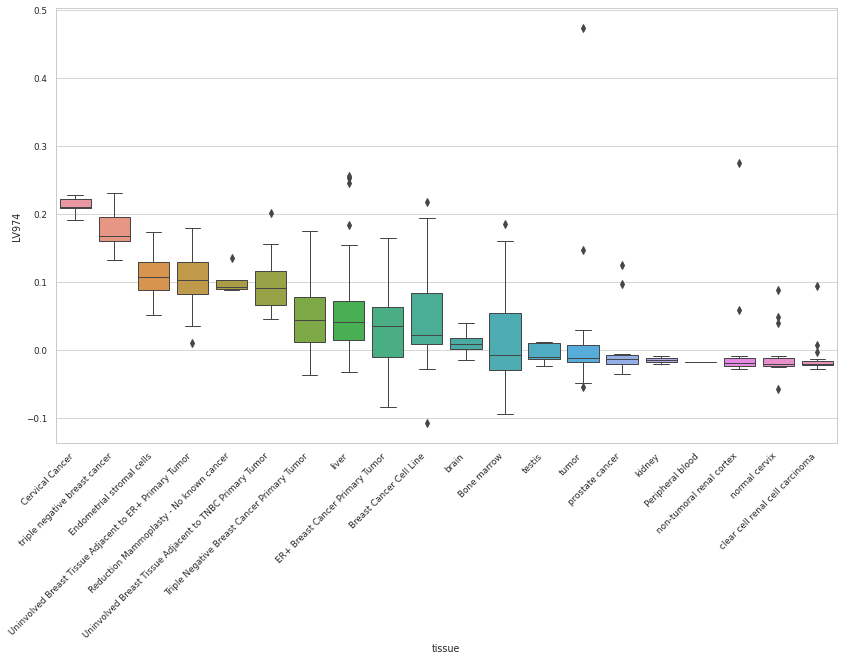

,pathway,LV index,AUC,p-value,FDR
1629,REACTOME_MITOCHONDRIAL_PROTEIN_IMPORT,678,0.742277,3.476169e-03,1.994175e-02
1631,KEGG_OXIDATIVE_PHOSPHORYLATION,678,0.982290,5.458481e-16,5.747488e-14
1633,REACTOME_TCA_CYCLE_AND_RESPIRATORY_ELECTRON_TR...,678,0.856376,2.596467e-10,9.656171e-09
1635,REACTOME_RESPIRATORY_ELECTRON_TRANSPORT_ATP_SY...,678,0.988348,1.054241e-12,5.939594e-11
1636,REACTOME_RESPIRATORY_ELECTRON_TRANSPORT,678,0.998043,7.331802e-11,3.100921e-09
1637,REACTOME_SRP_DEPENDENT_COTRANSLATIONAL_PROTEIN...,678,0.686728,7.384320e-04,6.033325e-03
1638,MIPS_55S_RIBOSOME_MITOCHONDRIAL,678,0.806485,5.168314e-06,8.197098e-05


SRP011924, SRP066729, SRP055569, SRP052978, SRP029889, SRP026315, SRP042161, SRP017933, SRP009266, SRP033135, SRP009862, SRP014428, SRP006475, SRP055810, SRP062177, SRP034712, SRP028301, SRP044206, SRP012056, SRP057196, SRP057118, SRP045573, SRP024268, SRP018838, SRP060416, SRP018719, SRP061888, SRP058840, SRP002915, SRP059775, SRP014867, SRP033276, SRP029899, SRP021478, SRP049500, SRP036821, SRP055513, SRP058773, SRP045666, SRP041706, SRP011185, SRP006575, SRP028336, SRP043368, SRP012461, SRP058740, SRP007947, 

/home/miltondp/projects/labs/greenelab/phenoplier/libs/data/recount2.py:320: UserWarning: Not all experiments data could be loaded (45 != 47)
  warnings.warn(


''

20463-Ever_heard_an_unreal_voice                                                                                                                                         3.710002
100920_2103-Type_milk_consumed_skimmed                                                                                                                                   3.058085
22617_5434-Job_SOC_coding_Chefs_cooks                                                                                                                                    2.959990
K11_CHRONPANC-Chronic_pancreatitis                                                                                                                                       2.945108
22601_34333162-Job_coding_public_relations_officer_press_officer_information_officer                                                                                     2.938326
20003_1140868080-Treatmentmedication_code_cyclizine                                                           

''

,gene_name,LV678,gene_band
0,UQCRQ,3.754246,5q31.1
1,NDUFB1,3.672410,14q32.12
2,COX8A,3.472975,11q13.1
3,UQCR11,3.360704,19p13.3
4,NDUFA4,3.333345,7p21.3
5,COX6A1,3.314685,12q24.31
6,NDUFA13,3.255578,19p13.11
7,NDUFB2,3.182677,7q34
8,COX6B1,3.124476,19q13.12
9,ATP5O,3.093498,21q22.11


tissue            0.023846
cell type         0.009898
tissue subtype    0.007427
dtype: float64

array(['SRP011924', 'SRP066729', 'SRP052978', 'SRP029889', 'SRP017933',
       'SRP014428', 'SRP057196', 'SRP057118', 'SRP045573', 'SRP024268',
       'SRP061888', 'SRP033276', 'SRP029899', 'SRP021478', 'SRP036821',
       'SRP055513', 'SRP045666', 'SRP041706', 'SRP006575', 'SRP028336',
       'SRP043368', 'SRP058740'], dtype=object)

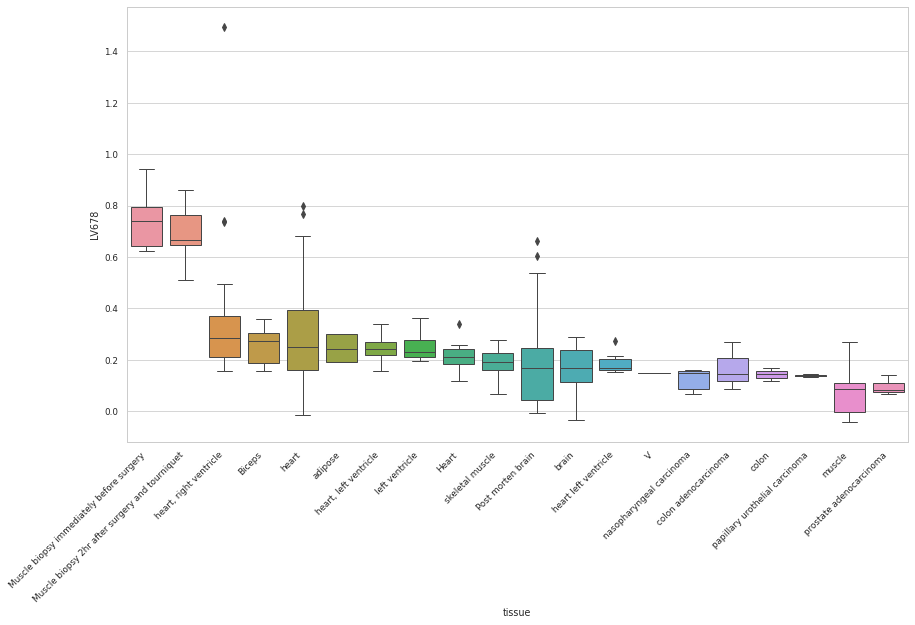

array(['SRP055569', 'SRP026315', 'SRP042161', 'SRP033135', 'SRP014428',
       'SRP062177', 'SRP044206', 'SRP057196', 'SRP060416', 'SRP049500',
       'SRP006575', 'SRP012461', 'SRP007947'], dtype=object)

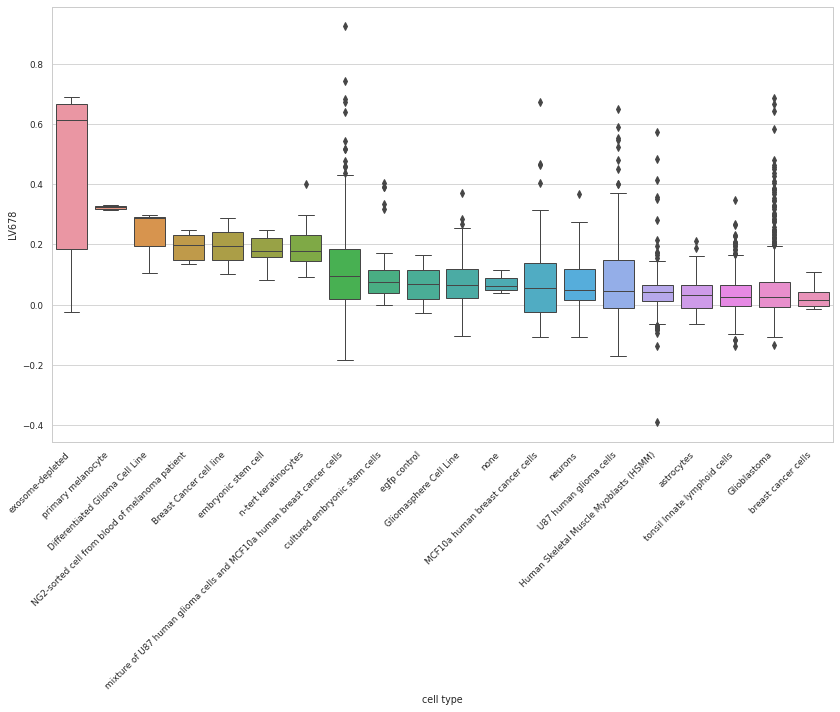

array(['SRP036821'], dtype=object)

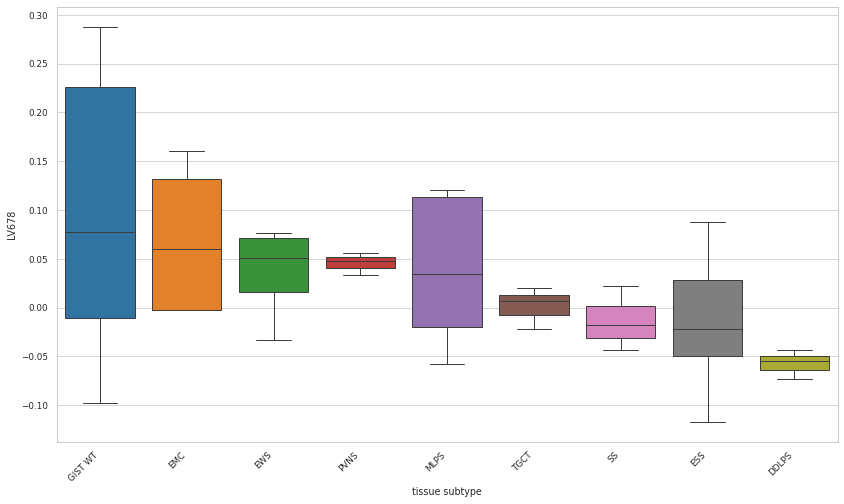

,pathway,LV index,AUC,p-value,FDR
1959,REACTOME_CLASS_B_2_SECRETIN_FAMILY_RECEPTORS,879,0.719230,0.003946,0.022252
1960,KEGG_BASAL_CELL_CARCINOMA,879,0.717422,0.006457,0.033004
1961,REACTOME_HEPARAN_SULFATE_HEPARIN_HS_GAG_METABO...,879,0.812376,0.001006,0.007719


SRP041179, SRP048761, SRP002079, SRP039397, SRP047194, SRP047233, SRP049553, SRP017684, SRP045876, SRP022028, SRP061416, SRP045308, SRP006561, SRP041738, SRP047516, SRP060650, SRP063669, SRP018848, SRP035482, SRP035417, SRP013999, SRP033432, SRP058804, SRP041159, SRP049340, SRP028804, SRP039346, SRP064624, SRP046749, SRP032928, SRP049203, SRP013825, SRP033267, SRP049475, SRP047339, SRP041377, SRP037579, SRP061682, SRP055569, SRP028118, SRP050499, SRP032798, SRP056957, SRP059205, SRP041751, SRP008225, SRP014671, SRP048825, SRP036821, SRP040525, SRP056076, SRP021134, SRP055440, SRP003021, SRP016140, 

''

3147_raw-Heel_quantitative_ultrasound_index_QUI_direct_entry                                                                                                                                         4.001473
78_raw-Heel_bone_mineral_density_BMD_Tscore_automated                                                                                                                                                4.001069
3148_raw-Heel_bone_mineral_density_BMD                                                                                                                                                               3.845474
3144_raw-Heel_Broadband_ultrasound_attenuation_direct_entry                                                                                                                                          3.844250
20003_1140873476-Treatmentmedication_code_tetralysal_300_capsule                                                                                                                

''

,gene_name,LV879,gene_band
0,WNT1,3.647542,12q13.12
1,FZD2,3.522519,17q21.31
2,TSPAN18,3.378119,11p11.2
3,WNT8B,3.199884,10q24.31
4,H2AFY2,2.831464,10q22.1
5,VANGL2,2.759527,1q23.2
6,SFRP2,2.737456,4q31.3
7,SMO,2.700968,7q32.1
8,WLS,2.568617,1p31.3
9,GLI3,2.503031,7p14.1


cell type         0.070021
tissue            0.045155
tissue subtype    0.006899
dtype: float64

array(['SRP041179', 'SRP048761', 'SRP047194', 'SRP047233', 'SRP049553',
       'SRP017684', 'SRP045876', 'SRP006561', 'SRP041738', 'SRP047516',
       'SRP060650', 'SRP063669', 'SRP018848', 'SRP035482', 'SRP035417',
       'SRP013999', 'SRP033432', 'SRP058804', 'SRP041159', 'SRP039346',
       'SRP046749', 'SRP032928', 'SRP049203', 'SRP033267', 'SRP047339',
       'SRP037579', 'SRP061682', 'SRP055569', 'SRP028118', 'SRP032798',
       'SRP056957', 'SRP059205', 'SRP041751', 'SRP008225', 'SRP056076',
       'SRP021134', 'SRP003021', 'SRP016140'], dtype=object)

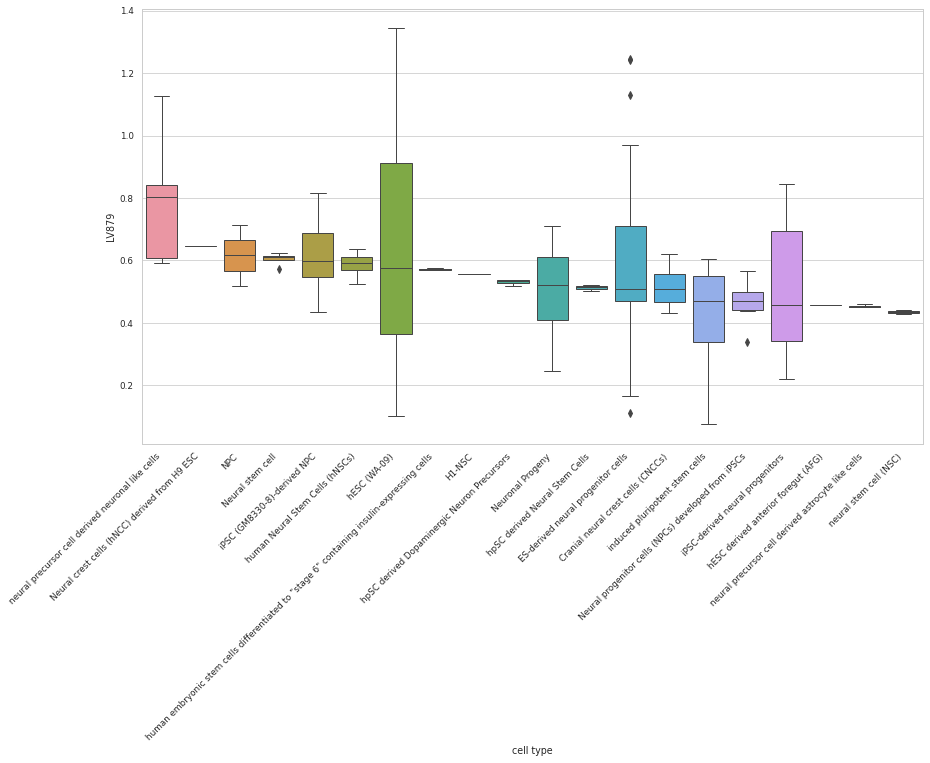

array(['SRP022028', 'SRP063669', 'SRP018848', 'SRP013825', 'SRP036821'],
      dtype=object)

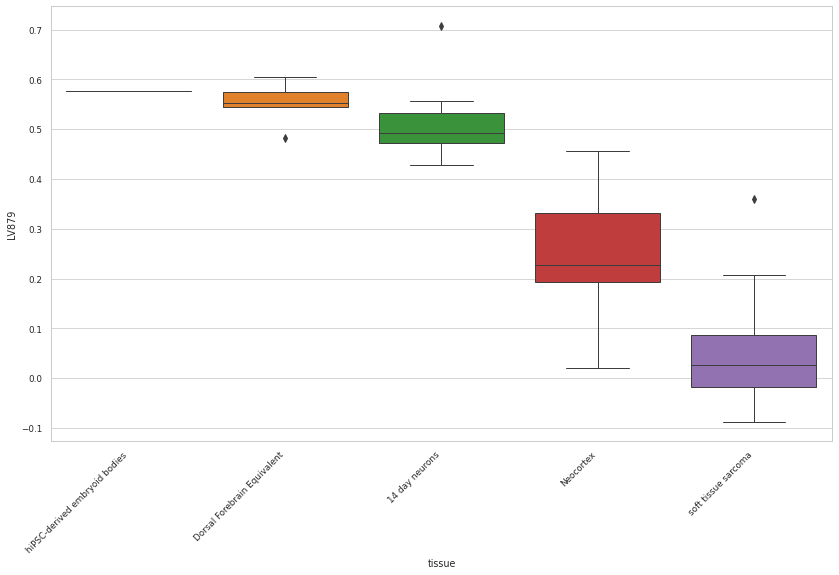

array(['SRP036821'], dtype=object)

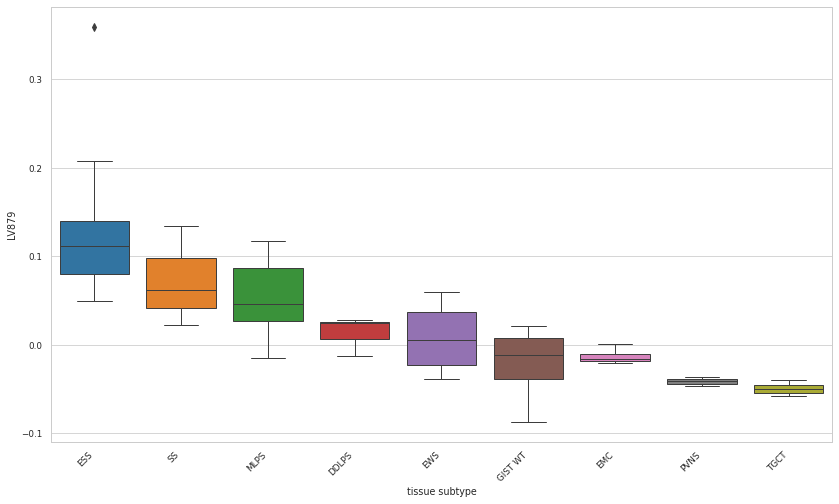

In [28]:
for lv_name in lvs_list:
    display(HTML(f"<h2>{lv_name}</h2>"))

    #     lv_name = lv_info["name"]
    lv_obj = LVAnalysis(lv_name, data)

    # show lv prior knowledge match (pathways)
    lv_pathways = multiplier_model_summary[
        multiplier_model_summary["LV index"].isin((lv_name[2:],))
        & (
            (multiplier_model_summary["FDR"] < 0.05)
            | (multiplier_model_summary["AUC"] >= 0.75)
        )
    ]
    display(lv_pathways)

    lv_data = lv_obj.get_experiments_data()

    display("")
    display(lv_obj.lv_traits.head(20))
    display("")
    display(lv_obj.lv_genes.head(10))

    lv_attrs = lv_obj.get_attributes_variation_score()
    _tmp = pd.Series(lv_attrs.index)
    lv_attrs = lv_attrs[
        _tmp.str.match(
            "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
            case=False,
            flags=re.IGNORECASE,
        ).values
    ].sort_values(ascending=False)
    display(lv_attrs)

    for _lva in lv_attrs.index:
        display(HTML(f"<h3>{_lva}</h3>"))
        display(lv_data[_lva].dropna().reset_index()["project"].unique())

        with sns.plotting_context("paper", font_scale=1.0), sns.axes_style("whitegrid"):
            fig, ax = plt.subplots(figsize=(14, 8))
            ax = lv_obj.plot_attribute(_lva, top_x_values=20)
            if ax is None:
                plt.close(fig)
                continue
            display(fig)
            plt.close(fig)